# LISA Traffic Sign Detection

In [4]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from collections import Counter
from matplotlib.image import imread
import cv2
import random
from ultralytics import YOLO
import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import logging
from PIL import Image as PILImage
from IPython.display import Image, display

In [5]:
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.16.2


This projects aims to detect traffic road signs. The data set used for this project is LISA Traffic sign dataset created by roboflow.

The project uses YOLO architecture to perform object detection.

The object detection is performed on 

1. Perform Exploratory data analysis on LISA traffic sign dataset
2. Fine-tune YOLO object detection model on raw dataset
3. Pre-preocess and augment images using open cv
4. Train and fine-tune YOLO on pre-processed dataset
5. Evaluate and Infer model on test images
6. Analyze metrics

In [11]:
# define data paths
TRAIN_PATH='../datasets/LISA road signs.v1i.yolov11/train/images'
TRAIN_LABELS = '../datasets/LISA road signs.v1i.yolov11/train/labels'
TRAIN_PREPROCESSED_PATH='../datasets/LISA road signs.v1i.yolov11/preprocessed/images'
TRAIN_PREPROCESSED_LABELS = '../datasets/LISA road signs.v1i.yolov11/preprocessed/labels'
VALID_PATH = '../datasets/LISA road signs.v1i.yolov11/valid/images'
TEST_PATH = '../datasets/LISA road signs.v1i.yolov11/test/images'
SAMPLE_PATH = '../datasets/LISA road signs.v1i.yolov11/sample/images'

## Dataset Analysis

In [13]:
# get labels
def get_labels():
    filenames = [f for f in os.listdir(TRAIN_PATH)]
    raw_labels = [label.split('_')[0] for label in filenames]
    class_labels = set(raw_labels)
    label_dict = Counter(raw_labels)
    sorted_label_dict = dict(sorted(label_dict.items(), key=lambda item: item[1]))
    return class_labels, sorted_label_dict
    
   
# Get all class names from filename. Example: keepRight_1333395677-avi_image8_png.rf.b1c606b890f97941185c51268eb110e2
class_labels, label_dict = get_labels()
print(class_labels)
print(label_dict)


{'turnLeft', 'rightLaneMustTurn', 'signalAhead', 'doNotEnter', 'thruMergeLeft', 'pedestrian', 'schoolSpeedLimit', 'curveLeft', 'merge', 'exitSpeedAdvisory', 'turnRight', 'rampSpeedAdvisory', 'pedestrianCrossing', 'stop', 'yield', 'laneEnds', 'speedLimit', 'stopAhead', 'yieldAhead', 'dip', '.DS', 'leftTurn', 'thruMergeRight', 'school', 'addedLane', 'rightLaneEnds', 'zoneAhead25', 'noRightTurn', 'schoolSpeedLimit25', 'curveRight', 'noLeftTurn', 'keepRight', 'curve', 'zoneAhead45', 'speedLimit45', 'truckSpeedLimit', 'slow', 'speedLimit65', 'doNotPass', 'roundabout', 'speedLimit35', 'speedLimitWhenFlashing', 'rampSpeedAdvisory20', 'rampSpeedAdvisory35', 'noUTurn', 'speedLimit25', 'speedLimit30', 'truckSpeedLimit55'}
{'.DS': 1, 'turnLeft': 6, 'doNotEnter': 8, 'curve': 8, 'rampSpeedAdvisory35': 8, 'speedLimitWhenFlashing': 8, 'thruMergeRight': 10, 'rampSpeedAdvisory20': 10, 'zoneAhead45': 14, 'doNotPass': 14, 'rightLaneEnds': 22, 'truckSpeedLimit55': 26, 'curveLeft': 28, 'truckSpeedLimit': 2

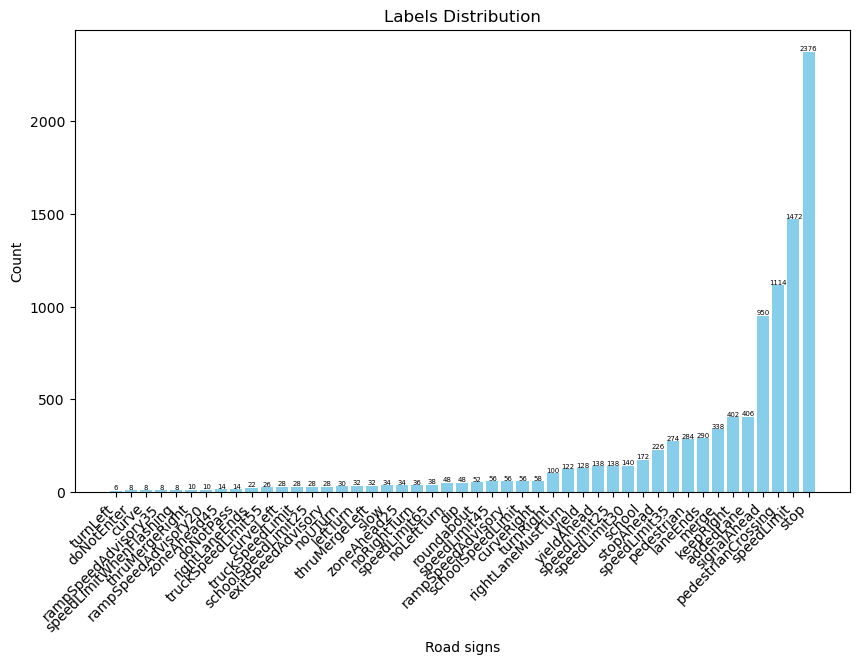

In [215]:
# plot distribution of labels
def plot_label_distribution(label_dict):
    labels = list(label_dict.keys())
    counts = list(label_dict.values())

    plt.figure(figsize=(10,6))
    bars = plt.bar(labels, counts, color='skyblue')

    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count), ha='center', va='bottom', fontsize=5)
        
    plt.title('Labels Distribution')
    plt.xlabel('Road signs')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    #plt.tight_layout()
    plt.show()

plot_label_distribution(label_dict)



As can be seen from the above plot, the dataset is highly imbalanced with many of the road signs consisting on of only few samples

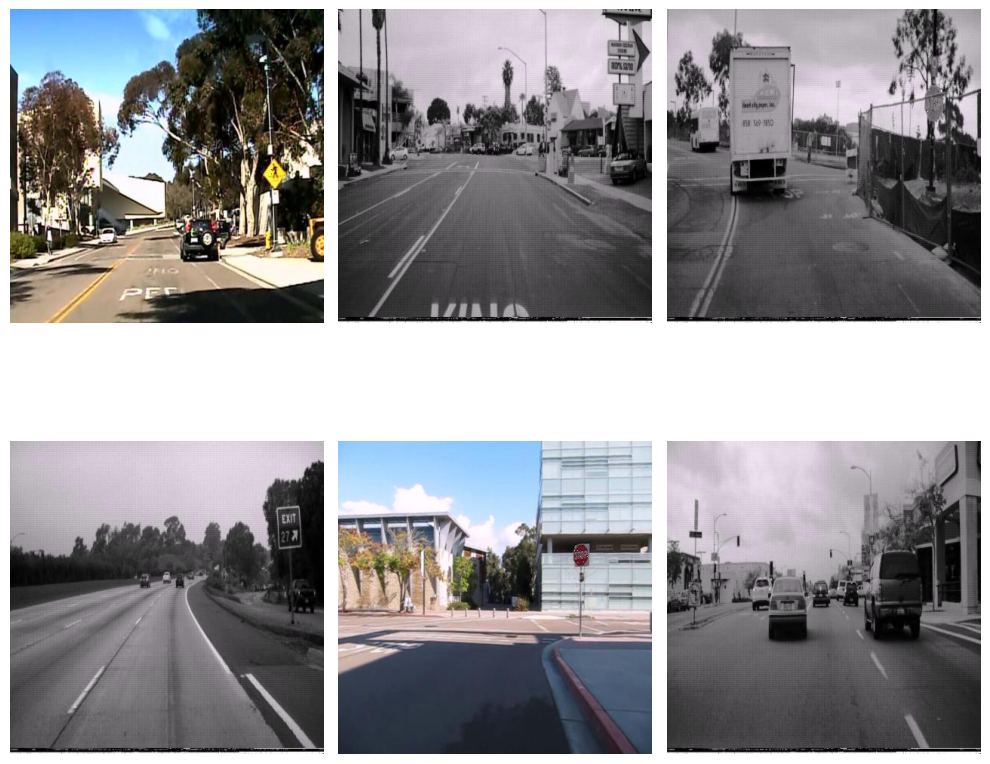

In [11]:
f, ax = plt.subplots(2, 3, figsize=(10, 10))
for idx, img_file in enumerate(os.listdir(TRAIN_PATH)[:6]):  # Limit to 6 images
    img_path = os.path.join(TRAIN_PATH, img_file)
    img = imread(img_path)
    row, col = divmod(idx, 3)  # Determine row and column
    ax[row, col].imshow(img)
    ax[row, col].axis('off')

plt.tight_layout()
plt.show()

In [12]:
filenames = sorted([f for f in os.listdir(TRAIN_PATH)])
labelnames = sorted([f for f in os.listdir(TRAIN_LABELS)])

# ensure both the list match in length
assert len(filenames) == len(labelnames)

data=[]
for file, label in zip(filenames, labelnames):
    image_path = os.path.join(TRAIN_PATH, file)
    label_path = os.path.join(TRAIN_LABELS, label)

    with open(label_path, 'r') as f:
        for line in  f:
            parts = line.strip().split()
            label = label.split('_')[0]
            x_center, y_center, width, height = map(float, parts[1:])

            # Append to dataset
            data.append({
                'filename' : file,
                'label' : label,
                'x_center' : x_center,
                'y_center' : y_center,
                'width' : width,
                'height' : height
            })

df = pd.DataFrame(data)

df.head()


    


filename      label  x_center  \
0  addedLane_1323813414-avi_image0_png.rf.3aeab74...  addedLane  0.365385   
1  addedLane_1323813414-avi_image0_png.rf.8e156cc...  addedLane  0.365385   
2  addedLane_1323813414-avi_image2_png.rf.d5d0fae...  addedLane  0.292067   
3  addedLane_1323813414-avi_image2_png.rf.db67207...  addedLane  0.292067   
4  addedLane_1323813414-avi_image3_png.rf.4c7a5ed...  addedLane  0.234375   

   y_center     width    height  
0  0.461538  0.057091  0.081731  
1  0.461538  0.057091  0.081731  
2  0.415865  0.079327  0.114784  
3  0.415865  0.079327  0.114784  
4  0.383413  0.091346  0.132812

In [96]:
df['label'].unique()

array(['addedLane', 'curveLeft', 'curveRight', 'curve', 'dip', 'doNotEnter', 'doNotPass', 'exitSpeedAdvisory', 'keepRight', 'laneEnds', 'leftTurn', 'merge', 'noLeftTurn', 'noRightTurn', 'noUTurn', 'pedestrianCrossing', 'pedestrian', 'rampSpeedAdvisory20', 'rampSpeedAdvisory35', 'rampSpeedAdvisory', 'rightLaneEnds',
       'rightLaneMustTurn', 'roundabout', 'schoolSpeedLimit25', 'schoolSpeedLimit', 'school', 'signalAhead', 'slow', 'speedLimit25', 'speedLimit30', 'speedLimit35', 'speedLimit45', 'speedLimit65', 'speedLimitWhenFlashing', 'speedLimit', 'stopAhead', 'stop', 'thruMergeLeft', 'thruMergeRight', 'truckSpeedLimit55',
       'truckSpeedLimit', 'turnLeft', 'turnRight', 'yieldAhead', 'yield', 'zoneAhead25', 'zoneAhead45'], dtype=object)

0.7475961538461539 0.6286057692307693 0.024639423076923076 0.03365384615384615
0.7475961538461539 0.6286057692307693 10 14
306 254 316 268


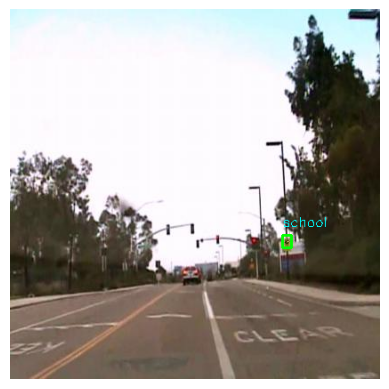

True

In [14]:
index = random.randint(0,11781)
x_center, y_center, width, height = df['x_center'][index], df['y_center'][index], df['width'][index], df['height'][index]
print(x_center, y_center, width, height)

file = os.path.join(TRAIN_PATH, df['filename'][index]) 
label = df['filename'][index].split('_')[0]
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape

# convert normalized co-ordinates to pixel values
x_c = int(x_center * w)
y_c = int(y_center * h)
box_width = int(width * w)
box_height = int(height * h)

print(x_center, y_center, box_width, box_height)

# calcualte the top left and bottm left corners
x1 = int(x_c - box_width / 2)
y1 = int(y_c - box_height / 2)
x2 = int(x_c + box_width / 2)
y2 = int(y_c + box_height / 2)

print(x1,y1,x2,y2)

# draw the bounding box
cv2.rectangle(image, (x1, y1), (x2, y2), color=(0,255,0), thickness = 2)

# add label text
cv2.putText(image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)


# display the image wiht bounding box

plt.imshow(image)
plt.axis('off')
plt.show()
#cv2.imshow("Image with boudning box", image)
#cv2.waitKey()
#cv2.destroyAllWindows()

#save the image
cv2.imwrite("output_image.jpg", image)

## Model Training

In [16]:
# Define the HOME directory
HOME = os.path.join(os.getcwd(), 'yolo')
print("HOME directory:", HOME)


# Install the YOLOv11 repository
!pip install -q git+https://github.com/THU-MIG/yolov10.git


HOME directory: /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/AAI521_LisaTrafficSign/yolo


In [17]:
# Create the weights directory
!mkdir -p HOME/weights

# Download pretrained weights using curl
!curl -L -o HOME/weights/yolov10n.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!curl -L -o HOME/weights/yolov10s.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!curl -L -o HOME/weights/yolov10m.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!curl -L -o HOME/weights/yolov10b.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!curl -L -o HOME/weights/yolov10x.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!curl -L -o HOME/weights/yolov10l.pt https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt

# List the files in the weights directory
!ls -lh HOME/weights


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.9M  100 10.9M    0     0  10.4M      0  0:00:01  0:00:01 --:--:-- 15.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 31.4M  100 31.4M    0     0  22.3M      0  0:00:01  0:00:01 --:--:-- 52.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 63.8M  100 63.8M    0     0  32.8M      0  0:00:01  0:00:01 --:--:-- 53.0M
  % Total    % Received % Xferd  Average Speed   Tim

### Training the model on raw image dataset

In [163]:
model_path = '../yolo11/weights/yolov10n.pt'
data_path = 'data.yaml'

# initialize the model
model = YOLO(model_path)

# train the model
model.train(
    data = data_path,
    epochs=10,
    batch=32,
    imgsz=416,
    name='yolo10n_lisa2',
    device='mps'
)


New https://pypi.org/project/ultralytics/8.3.38 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.5.1 MPS (Apple M3 Max)
engine/trainer: task=detect, mode=train, model=../yolo11/weights/yolov10n.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, val_period=1, cache=False, device=mps, workers=8, project=None, name=yolo10n_lisa22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False

train: Scanning /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/train_preprocessed/labels.cache... 9926 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9926/9926 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/train_preprocessed/images/pedestrianCrossing_1333397756-avi_image29_png.rf.d90694bafe85e5ae2f072a588cbceb3a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/train_preprocessed/images/pedestrianCrossing_1333397756-avi_image29_png.rf.e5e02a383ac788c9afa34a561f222e2d.jpg: 1 duplicate labels removed



val: Scanning /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/valid_preprocessed/labels.cache... 993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 993/993 [00:00<?, ?it/s]

Plotting labels to runs/detect/yolo10n_lisa22/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000196, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/detect/yolo10n_lisa22
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/10         0G      1.613      5.727      1.029      1.737      8.406     0.9758          7        416: 100%|██████████| 311/311 [13:53<00:00,  2.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [02:29<00:00,  9.36s/it]


                   all        993       1191      0.652     0.0595     0.0506     0.0335

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/10         0G      1.341      3.286       0.94      1.513      5.919     0.9062          7        416: 100%|██████████| 311/311 [09:05<00:00,  1.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:54<00:00,  3.43s/it]


                   all        993       1191      0.691      0.102      0.104     0.0725

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/10         0G      1.221      2.429     0.9225      1.405      4.665        0.9          9        416: 100%|██████████| 311/311 [07:16<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:52<00:00,  3.29s/it]


                   all        993       1191      0.713      0.168      0.192      0.133

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/10         0G      1.146      1.947        0.9      1.334      3.663     0.8839          6        416: 100%|██████████| 311/311 [05:26<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:51<00:00,  3.21s/it]


                   all        993       1191      0.681      0.237      0.287      0.217

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/10         0G      1.094      1.579     0.8881      1.282      2.921     0.8772          6        416: 100%|██████████| 311/311 [04:25<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:34<00:00,  2.15s/it]

                   all        993       1191      0.602      0.347      0.406        0.3



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/10         0G      1.044       1.32     0.8806      1.239      2.385     0.8734          5        416: 100%|██████████| 311/311 [04:54<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:37<00:00,  2.34s/it]


                   all        993       1191      0.703      0.383      0.455      0.337

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/10         0G      1.004       1.15      0.872        1.2      2.045     0.8655          5        416: 100%|██████████| 311/311 [04:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:29<00:00,  1.85s/it]


                   all        993       1191      0.577      0.501      0.536      0.409

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/10         0G     0.9663      1.023     0.8667      1.165      1.801     0.8627          9        416: 100%|██████████| 311/311 [04:13<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:32<00:00,  2.05s/it]


                   all        993       1191      0.653      0.506      0.569      0.432

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/10         0G     0.9325     0.9205      0.857      1.132      1.618     0.8542          6        416: 100%|██████████| 311/311 [04:32<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:29<00:00,  1.82s/it]


                   all        993       1191      0.677      0.568      0.621       0.48

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/10         0G     0.9071     0.8674     0.8518      1.106      1.508     0.8514          4        416: 100%|██████████| 311/311 [04:17<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


                   all        993       1191      0.657      0.631      0.637        0.5

10 epochs completed in 1.209 hours.
Optimizer stripped from runs/detect/yolo10n_lisa22/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/yolo10n_lisa22/weights/best.pt, 5.8MB

Validating runs/detect/yolo10n_lisa22/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.5.1 MPS (Apple M3 Max)
YOLOv10n summary (fused): 285 layers, 2712746 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:38<00:00,  2.38s/it]


                   all        993       1191      0.665      0.627      0.638        0.5
             addedLane        993         33      0.723       0.97      0.934      0.742
             curveLeft        993          7      0.504      0.286      0.428      0.344
            curveRight        993          8      0.631      0.875      0.605      0.541
                   dip        993          9          1      0.273      0.532      0.425
            doNotEnter        993          3          1          0     0.0238     0.0133
             doNotPass        993          1      0.488      0.977      0.497      0.351
          intersection        993          1          1          0          0          0
             keepRight        993         58      0.597      0.767      0.762      0.554
              laneEnds        993         23      0.642      0.826      0.812        0.6
                 merge        993         38       0.78       0.93      0.959      0.803
            noLeftTur

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x372b564a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.03603

### Image pre-processing

In [67]:
def custom_preprocess(image_path):
    # Read the image
    image = cv2.imread(os.path.join(TRAIN_PATH, image_path))
    
    image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert to RGB for display

    # Histogram Equalization (For grayscale images)
    img_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    hist_eq = cv2.equalizeHist(img_gray)

     # CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(img_gray)

    # Convert CLAHE image back to 3-channel BGR for futher processing 
    clahe_bgr = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2BGR)

    # Sharpening Filter
    kernel = np.array([[0, -1, 0], 
                    [-1, 5, -1], 
                    [0, -1, 0]])
    sharpened = cv2.filter2D(clahe_bgr, -1, kernel)

    # Noise Reduction (Denoising)
    denoised = cv2.fastNlMeansDenoisingColored(sharpened, None, 10, 10, 7, 21)

    return hist_eq, clahe_img, sharpened, denoised

In [ ]:
hist_eq, clahe_img, sharpened, denoised = custom_preprocess(file)

In [70]:
# Set up logging to capture errors
logging.basicConfig(filename="error_log.txt", level=logging.ERROR)
cnt = 1
for file in tqdm.tqdm(os.listdir(TRAIN_PATH), desc='Preprocessing Image file...'):
    try:
        # Extract base filename and label
        base = file.split('.jpg')[0]
        label = base + '.txt'

        # Preprocess the image
        hist_eq, clahe_img, sharpened, denoised = custom_preprocess(file)

        # Save processed images
        cv2.imwrite(os.path.join(TRAIN_PREPROCESSED_PATH, 'histeq_' + file), hist_eq)
        cv2.imwrite(os.path.join(TRAIN_PREPROCESSED_PATH, 'clahe_' + file), clahe_img)
        cv2.imwrite(os.path.join(TRAIN_PREPROCESSED_PATH, 'sharp_' + file), sharpened)
        cv2.imwrite(os.path.join(TRAIN_PREPROCESSED_PATH, 'denoise_' + file), denoised)

        # Prepare file paths for labels
        original_file = os.path.join(TRAIN_LABELS, label)
        hist_eq_label = os.path.join(TRAIN_PREPROCESSED_LABELS, 'histeq_' + label)
        clahe_label = os.path.join(TRAIN_PREPROCESSED_LABELS, 'clahe_' + label)
        sharp_label = os.path.join(TRAIN_PREPROCESSED_LABELS, 'sharp_' + label)
        denoise_label = os.path.join(TRAIN_PREPROCESSED_LABELS, 'denoise_' + label)

        # Copy label files
        shutil.copy(original_file, hist_eq_label)
        shutil.copy(original_file, clahe_label)
        shutil.copy(original_file, sharp_label)
        shutil.copy(original_file, denoise_label)

        cnt+=1 # file count
    except Exception as e:
        # Log the error and the file that caused it
        logging.error(f"Error processing file {file}: {e}")
        print(f"Error processing file {file}: {e}")

Preprocessing Image file...:  15%|█▍        | 1483/9927 [06:37<37:42,  3.73it/s]

Error processing file .DS_Store: OpenCV(4.10.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



Preprocessing Image file...: 100%|██████████| 9927/9927 [44:34<00:00,  3.71it/s]


Below are the set of augmented images as a result of pre-processing

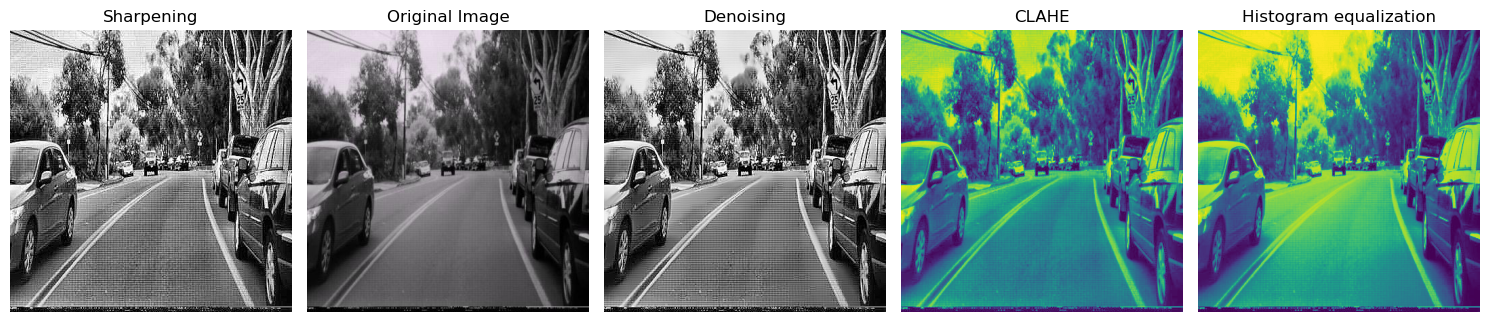

In [30]:
AUG_PATH = '../Submission/screenshots/data_aug'
image_files = os.listdir(AUG_PATH)[:5]  # Limit to 5 images
img_title = ['Sharpening','Original Image', 'Denoising', 'CLAHE', 'Histogram equalization'] 

f, ax = plt.subplots(1, 5, figsize=(15, 5))  # Create a single row with 5 plots
ax = ax.flatten()  # Flatten to ensure compatibility

for idx, img_file in enumerate(image_files):
    img_path = os.path.join(AUG_PATH, img_file)
    img = imread(img_path)
    ax[idx].imshow(img)
    ax[idx].axis('off')  # Remove axes
    ax[idx].set_title(img_title[idx], fontsize=12)  # Set title with smaller font size

# Hide unused subplots if fewer than 5 images
for idx in range(len(image_files), len(ax)):
    ax[idx].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [6]:
model_path = '../yolo11/weights/yolov10n.pt'
data_path = 'data.yaml'

# initialize the model
model = YOLO(model_path)

# train the model
model.train(
    data = data_path,
    epochs=100,
    batch=16,
    name='yolo10n_lisa',
    device='mps',
    patience=3
)


New https://pypi.org/project/ultralytics/8.3.39 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.5.1 MPS (Apple M3 Max)
engine/trainer: task=detect, mode=train, model=../yolo11/weights/yolov10n.pt, data=data.yaml, epochs=100, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=mps, workers=8, project=None, name=yolo10n_lisa14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

train: Scanning /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/train/labels.cache... 9926 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9926/9926 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/train/images/pedestrianCrossing_1333397756-avi_image29_png.rf.d90694bafe85e5ae2f072a588cbceb3a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/train/images/pedestrianCrossing_1333397756-avi_image29_png.rf.e5e02a383ac788c9afa34a561f222e2d.jpg: 1 duplicate labels removed



val: Scanning /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11/valid/labels.cache... 993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 993/993 [00:00<?, ?it/s]

Plotting labels to runs/detect/yolo10n_lisa14/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolo10n_lisa14
Starting training for 100 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      1/100         0G      1.367      5.152      1.008       1.48      9.826      0.961         11        640: 100%|██████████| 621/621 [07:25<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.16it/s]

                   all        993       1191      0.612      0.113     0.0853     0.0585



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      2/100         0G      1.259      3.382     0.9897      1.431      7.211     0.9816         12        640: 100%|██████████| 621/621 [06:48<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.26it/s]

                   all        993       1191      0.685      0.158      0.146     0.0951



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      3/100         0G      1.285      3.012      1.018      1.461      4.332      1.023          6        640: 100%|██████████| 621/621 [07:59<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:55<00:00,  1.75s/it]

                   all        993       1191      0.758      0.143      0.172      0.118



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      4/100         0G      1.261      2.418      1.033      1.462      2.452      1.051         12        640: 100%|██████████| 621/621 [08:45<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]

                   all        993       1191      0.728      0.183      0.245      0.171



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      5/100         0G      1.174       1.78      1.008      1.386      1.881      1.028         10        640: 100%|██████████| 621/621 [08:27<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:31<00:00,  1.02it/s]

                   all        993       1191      0.577      0.272      0.293      0.219



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      6/100         0G      1.118       1.45     0.9874      1.334      1.625      1.011          6        640: 100%|██████████| 621/621 [07:45<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.17it/s]

                   all        993       1191      0.692      0.326      0.379      0.279



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      7/100         0G      1.075      1.282     0.9758      1.294      1.468     0.9984          5        640: 100%|██████████| 621/621 [07:31<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.26it/s]

                   all        993       1191      0.765      0.376      0.494      0.362



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      8/100         0G      1.044      1.172      0.964      1.257      1.365     0.9882         10        640: 100%|██████████| 621/621 [07:36<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.17it/s]

                   all        993       1191      0.583      0.477      0.503      0.391



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      9/100         0G      1.024      1.083      0.953      1.237      1.277     0.9777         11        640: 100%|██████████| 621/621 [07:13<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.23it/s]

                   all        993       1191      0.766      0.432       0.57      0.444



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     10/100         0G       1.01      1.004     0.9476      1.208      1.167     0.9666         10        640: 100%|██████████| 621/621 [07:11<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.14it/s]

                   all        993       1191      0.716      0.486      0.601      0.468



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     11/100         0G     0.9858     0.9607     0.9382      1.186      1.138     0.9614          9        640: 100%|██████████| 621/621 [07:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]

                   all        993       1191      0.748      0.469      0.606      0.457



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     12/100         0G      0.973     0.9103     0.9323       1.18      1.073     0.9569          9        640: 100%|██████████| 621/621 [07:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:36<00:00,  1.13s/it]

                   all        993       1191      0.668      0.601       0.66      0.523



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     13/100         0G     0.9663     0.8768      0.933      1.163      1.028     0.9512          8        640: 100%|██████████| 621/621 [07:18<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:32<00:00,  1.01s/it]

                   all        993       1191      0.647      0.651      0.688      0.537



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     14/100         0G     0.9498     0.8492     0.9238      1.153     0.9899     0.9457         11        640: 100%|██████████| 621/621 [07:04<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:36<00:00,  1.14s/it]

                   all        993       1191      0.687      0.651      0.731       0.58



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     15/100         0G     0.9427     0.8279       0.92      1.135     0.9549     0.9372         10        640: 100%|██████████| 621/621 [07:14<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]

                   all        993       1191      0.716      0.672      0.735      0.585



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     16/100         0G     0.9324     0.7822     0.9227      1.127     0.9138     0.9444          9        640: 100%|██████████| 621/621 [07:09<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.14it/s]

                   all        993       1191      0.782       0.67      0.771      0.613



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     17/100         0G     0.9259     0.7598     0.9189      1.117     0.8836     0.9373         12        640: 100%|██████████| 621/621 [07:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]

                   all        993       1191      0.729      0.727       0.78      0.626



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     18/100         0G     0.9126     0.7382     0.9112      1.097     0.8422     0.9303         10        640: 100%|██████████| 621/621 [07:24<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:30<00:00,  1.03it/s]

                   all        993       1191      0.727       0.73      0.798      0.634



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     19/100         0G     0.9091     0.7209     0.9109        1.1     0.8356     0.9313         11        640: 100%|██████████| 621/621 [07:10<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]

                   all        993       1191       0.83       0.68       0.79      0.628



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     20/100         0G     0.9094     0.7083     0.9111      1.094     0.7994     0.9282          9        640: 100%|██████████| 621/621 [24:12<00:00,  2.34s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]

                   all        993       1191      0.857        0.7       0.81      0.636



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     21/100         0G     0.8924      0.697     0.9066      1.075     0.7969     0.9244          7        640: 100%|██████████| 621/621 [1:33:28<00:00,  9.03s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]

                   all        993       1191      0.725      0.785      0.842      0.676



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     22/100         0G     0.8899     0.6825     0.9064      1.067      0.775     0.9224         13        640: 100%|██████████| 621/621 [53:29<00:00,  5.17s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]

                   all        993       1191      0.718      0.766       0.84      0.674



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     23/100         0G     0.8729     0.6599     0.9009      1.052     0.7486     0.9202          7        640: 100%|██████████| 621/621 [56:18<00:00,  5.44s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.25it/s]

                   all        993       1191      0.832      0.755      0.878      0.705



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     24/100         0G      0.871     0.6462     0.8986      1.049      0.724     0.9152          9        640: 100%|██████████| 621/621 [41:06<00:00,  3.97s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]

                   all        993       1191       0.81      0.793      0.826      0.666



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     25/100         0G     0.8718     0.6395     0.8965      1.044     0.7156     0.9148          7        640: 100%|██████████| 621/621 [31:46<00:00,  3.07s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]

                   all        993       1191      0.781      0.806      0.852      0.692



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


     26/100         0G     0.8606     0.6189     0.8971      1.031      0.683     0.9114          9        640: 100%|██████████| 621/621 [29:01<00:00,  2.81s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [13:47<00:00, 25.86s/it]   

                   all        993       1191      0.826      0.784      0.868      0.694
Stopping training early as no improvement observed in last 3 epochs. Best results observed at epoch 23, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



26 epochs completed in 8.356 hours.
Optimizer stripped from runs/detect/yolo10n_lisa14/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/yolo10n_lisa14/weights/best.pt, 5.8MB

Validating runs/detect/yolo10n_lisa14/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.5.1 MPS (Apple M3 Max)
YOLOv10n summary (fused): 285 layers, 2712746 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:54<00:00,  1.71s/it]


                   all        993       1191      0.831      0.755      0.878      0.706
             addedLane        993         33      0.979      0.939      0.988      0.826
             curveLeft        993          7       0.73      0.286      0.751       0.67
            curveRight        993          8      0.553      0.619      0.705      0.641
                   dip        993          9      0.776      0.772      0.884      0.701
            doNotEnter        993          3      0.885          1      0.995      0.697
             doNotPass        993          1          1          0      0.995      0.895
          intersection        993          1          1          0          0          0
             keepRight        993         58      0.919      0.914      0.933      0.733
              laneEnds        993         23      0.864      0.957      0.957      0.755
                 merge        993         38      0.952          1      0.995      0.862
            noLeftTur

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0xa6e089870>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.03603

### Model training after image pre-processing and training

In [4]:
# Train YOLO model with preprocessed images
model = YOLO("yolov10n.pt")  # Load YOLO with pre-trained weights
model.train(
    data='data1.yaml',  # Your YAML file with data configuration
    epochs=20,       # Number of training epochs
    batch=16,        # Batch size
    name="yolo10n_preprocessed",  # Experiment name
    device="mps",       # GPU (or "cpu" for CPU training)
    patience=3,      # Early stopping after 5 epochs of no improvement
    save=True,
    plots=True      # plot visualization graphs
)

New https://pypi.org/project/ultralytics/8.3.40 available 😃 Update with 'pip install -U ultralytics'


/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/ultralytics/nn/tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu"

Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.5.1 MPS (Apple M3 Max)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=data1.yaml, epochs=20, time=None, patience=3, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=mps, workers=8, project=None, name=yolo10n_preprocessed9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/ultralytics/engine/trainer.py:276: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11 - 1201/train/labels.cache... 49629 images, 1 backgrounds, 0 corrupt: 100%|██████████| 49630/49630 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11 - 1201/train/images/clahe_pedestrianCrossing_1333397756-avi_image29_png.rf.d90694bafe85e5ae2f072a588cbceb3a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11 - 1201/train/images/clahe_pedestrianCrossing_1333397756-avi_image29_png.rf.e5e02a383ac788c9afa34a561f222e2d.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11 - 1201/train/images/denoise_pedestrianCrossing_1333397756-avi_image29_png.rf.d90694bafe85e5ae2f072a588cbceb3a.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11 - 1201/tra


val: Scanning /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/datasets/LISA road signs.v1i.yolov11 - 1201/valid/labels.cache... 993 images, 0 backgrounds, 0 corrupt: 100%|██████████| 993/993 [00:00<?, ?it/s]

Plotting labels to runs/detect/yolo10n_preprocessed9/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/yolo10n_preprocessed9
Starting training for 20 epochs...

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       1/20         0G      1.283      4.017     0.9935      1.416      8.178     0.9623         20        640: 100%|██████████| 3102/3102 [47:29<00:00,  1.09it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [03:09<00:00,  5.92s/it]


                   all        993       1191      0.708      0.258      0.286      0.207

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       2/20         0G      1.145      2.246     0.9644      1.331      2.974      0.972         29        640: 100%|██████████| 3102/3102 [38:33<00:00,  1.34it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:35<00:00,  1.10s/it]

                   all        993       1191       0.65       0.41      0.475      0.356



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       3/20         0G      1.124      1.498     0.9744      1.333       1.59     0.9958         29        640: 100%|██████████| 3102/3102 [36:07<00:00,  1.43it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:47<00:00,  1.48s/it]

                   all        993       1191       0.77      0.495      0.623      0.477



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       4/20         0G      1.066      1.086     0.9634      1.285      1.272     0.9893         24        640: 100%|██████████| 3102/3102 [36:35<00:00,  1.41it/s]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:48<00:00,  1.51s/it]

                   all        993       1191      0.697      0.722      0.791      0.618



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       5/20         0G     0.9938     0.8591     0.9381      1.203      1.007     0.9612         23        640: 100%|██████████| 3102/3102 [2:09:30<00:00,  2.51s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]

                   all        993       1191      0.892      0.737      0.847      0.662



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       6/20         0G     0.9458     0.7434     0.9233      1.144     0.8639     0.9439         22        640: 100%|██████████| 3102/3102 [3:25:18<00:00,  3.97s/it]     
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.11it/s]

                   all        993       1191      0.873      0.838      0.897       0.73



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       7/20         0G     0.9042     0.6664     0.9094      1.091     0.7587     0.9281         25        640: 100%|██████████| 3102/3102 [55:32<00:00,  1.07s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.16it/s]

                   all        993       1191      0.849      0.887      0.915      0.745



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       8/20         0G     0.8746     0.6138     0.9009      1.055     0.6934     0.9177         22        640: 100%|██████████| 3102/3102 [35:57<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

                   all        993       1191      0.882      0.888      0.927      0.769



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


       9/20         0G     0.8496     0.5747     0.8939      1.019     0.6323      0.909         22        640: 100%|██████████| 3102/3102 [36:35<00:00,  1.41it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

                   all        993       1191      0.944      0.871      0.927      0.771



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      10/20         0G     0.8282     0.5436     0.8875     0.9967     0.5913     0.9013         19        640: 100%|██████████| 3102/3102 [36:20<00:00,  1.42it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]

                   all        993       1191      0.954      0.877      0.936      0.789


Closing dataloader mosaic

      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      11/20         0G     0.7655     0.4398     0.8826     0.8777     0.3939     0.8946         14        640: 100%|██████████| 3102/3102 [32:51<00:00,  1.57it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

                   all        993       1191      0.949       0.89      0.955      0.804



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      12/20         0G      0.739     0.4127     0.8757      0.849      0.362      0.886         15        640: 100%|██████████| 3102/3102 [32:40<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

                   all        993       1191      0.948      0.908      0.958      0.817



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      13/20         0G     0.7163     0.3926     0.8677     0.8188     0.3416     0.8758         18        640: 100%|██████████| 3102/3102 [33:00<00:00,  1.57it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.16it/s]

                   all        993       1191      0.913      0.928      0.959       0.82



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      14/20         0G     0.6973     0.3758     0.8621     0.7996     0.3218     0.8705         16        640: 100%|██████████| 3102/3102 [32:44<00:00,  1.58it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.14it/s]

                   all        993       1191      0.941      0.951      0.963      0.821



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      15/20         0G     0.6754     0.3594     0.8563      0.772     0.3023      0.863         15        640: 100%|██████████| 3102/3102 [32:58<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]

                   all        993       1191      0.933      0.934      0.957      0.817



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      16/20         0G     0.6546     0.3441      0.851     0.7482     0.2853     0.8565         17        640: 100%|██████████| 3102/3102 [33:06<00:00,  1.56it/s] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.14it/s]

                   all        993       1191      0.952      0.931      0.959       0.82



      Epoch    GPU_mem     box_om     cls_om     dfl_om     box_oo     cls_oo     dfl_oo  Instances       Size


      17/20         0G     0.6343     0.3294     0.8446     0.7237     0.2701     0.8498         18        640: 100%|██████████| 3102/3102 [33:12<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:28<00:00,  1.13it/s]

                   all        993       1191      0.956       0.93      0.957      0.821
Stopping training early as no improvement observed in last 3 epochs. Best results observed at epoch 14, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



17 epochs completed in 15.048 hours.
Optimizer stripped from runs/detect/yolo10n_preprocessed9/weights/last.pt, 5.8MB
Optimizer stripped from runs/detect/yolo10n_preprocessed9/weights/best.pt, 5.8MB

Validating runs/detect/yolo10n_preprocessed9/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.5.1 MPS (Apple M3 Max)
YOLOv10n summary (fused): 285 layers, 2712746 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:55<00:00,  1.73s/it]


                   all        993       1191      0.941       0.95      0.963      0.822
             addedLane        993         33          1      0.978      0.995       0.89
             curveLeft        993          7      0.976          1      0.995      0.873
            curveRight        993          8      0.865          1      0.954      0.828
                   dip        993          9          1      0.993      0.995      0.885
            doNotEnter        993          3      0.926          1      0.995       0.73
             doNotPass        993          1      0.963          1      0.995      0.895
          intersection        993          1          1          0          0          0
             keepRight        993         58      0.982      0.962      0.968       0.84
              laneEnds        993         23          1      0.977      0.995      0.837
                 merge        993         38          1      0.963      0.995       0.89
            noLeftTur

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x3c88e8370>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.03603

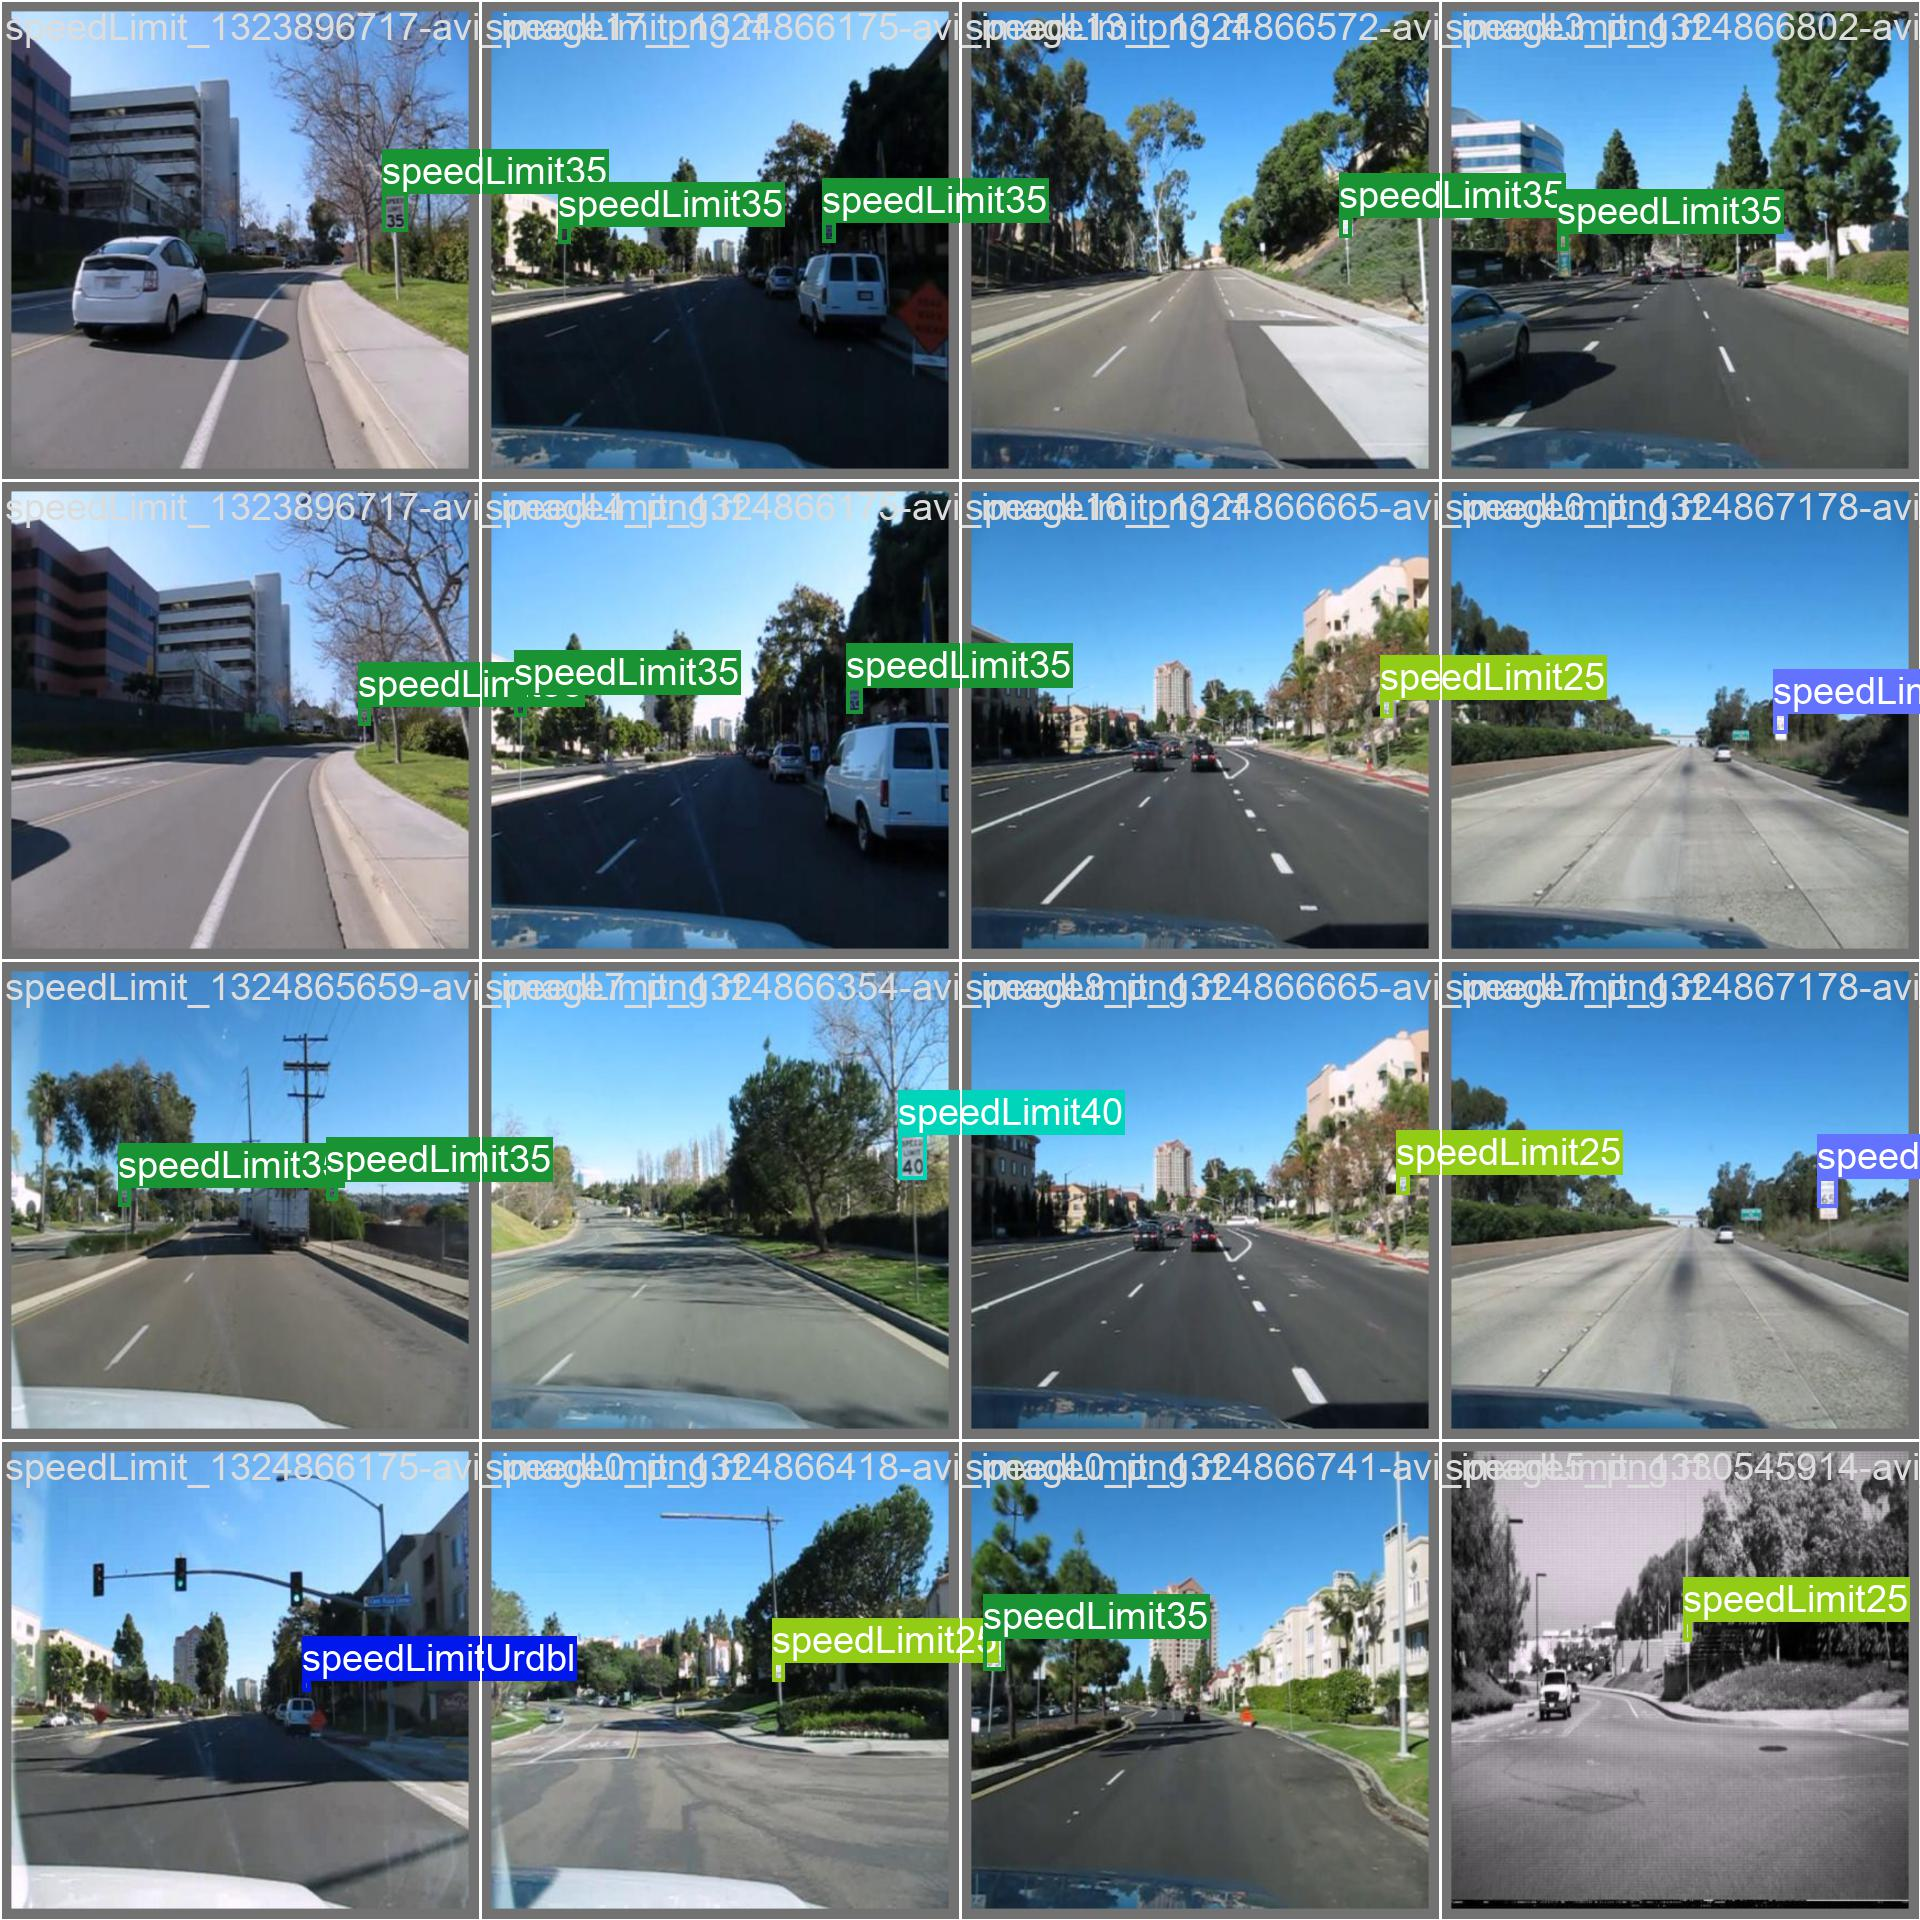

In [10]:
results_path = f'runs/detect/yolo10n_preprocessed9/val_batch1_labels.jpg'
display(Image(filename=results_path))

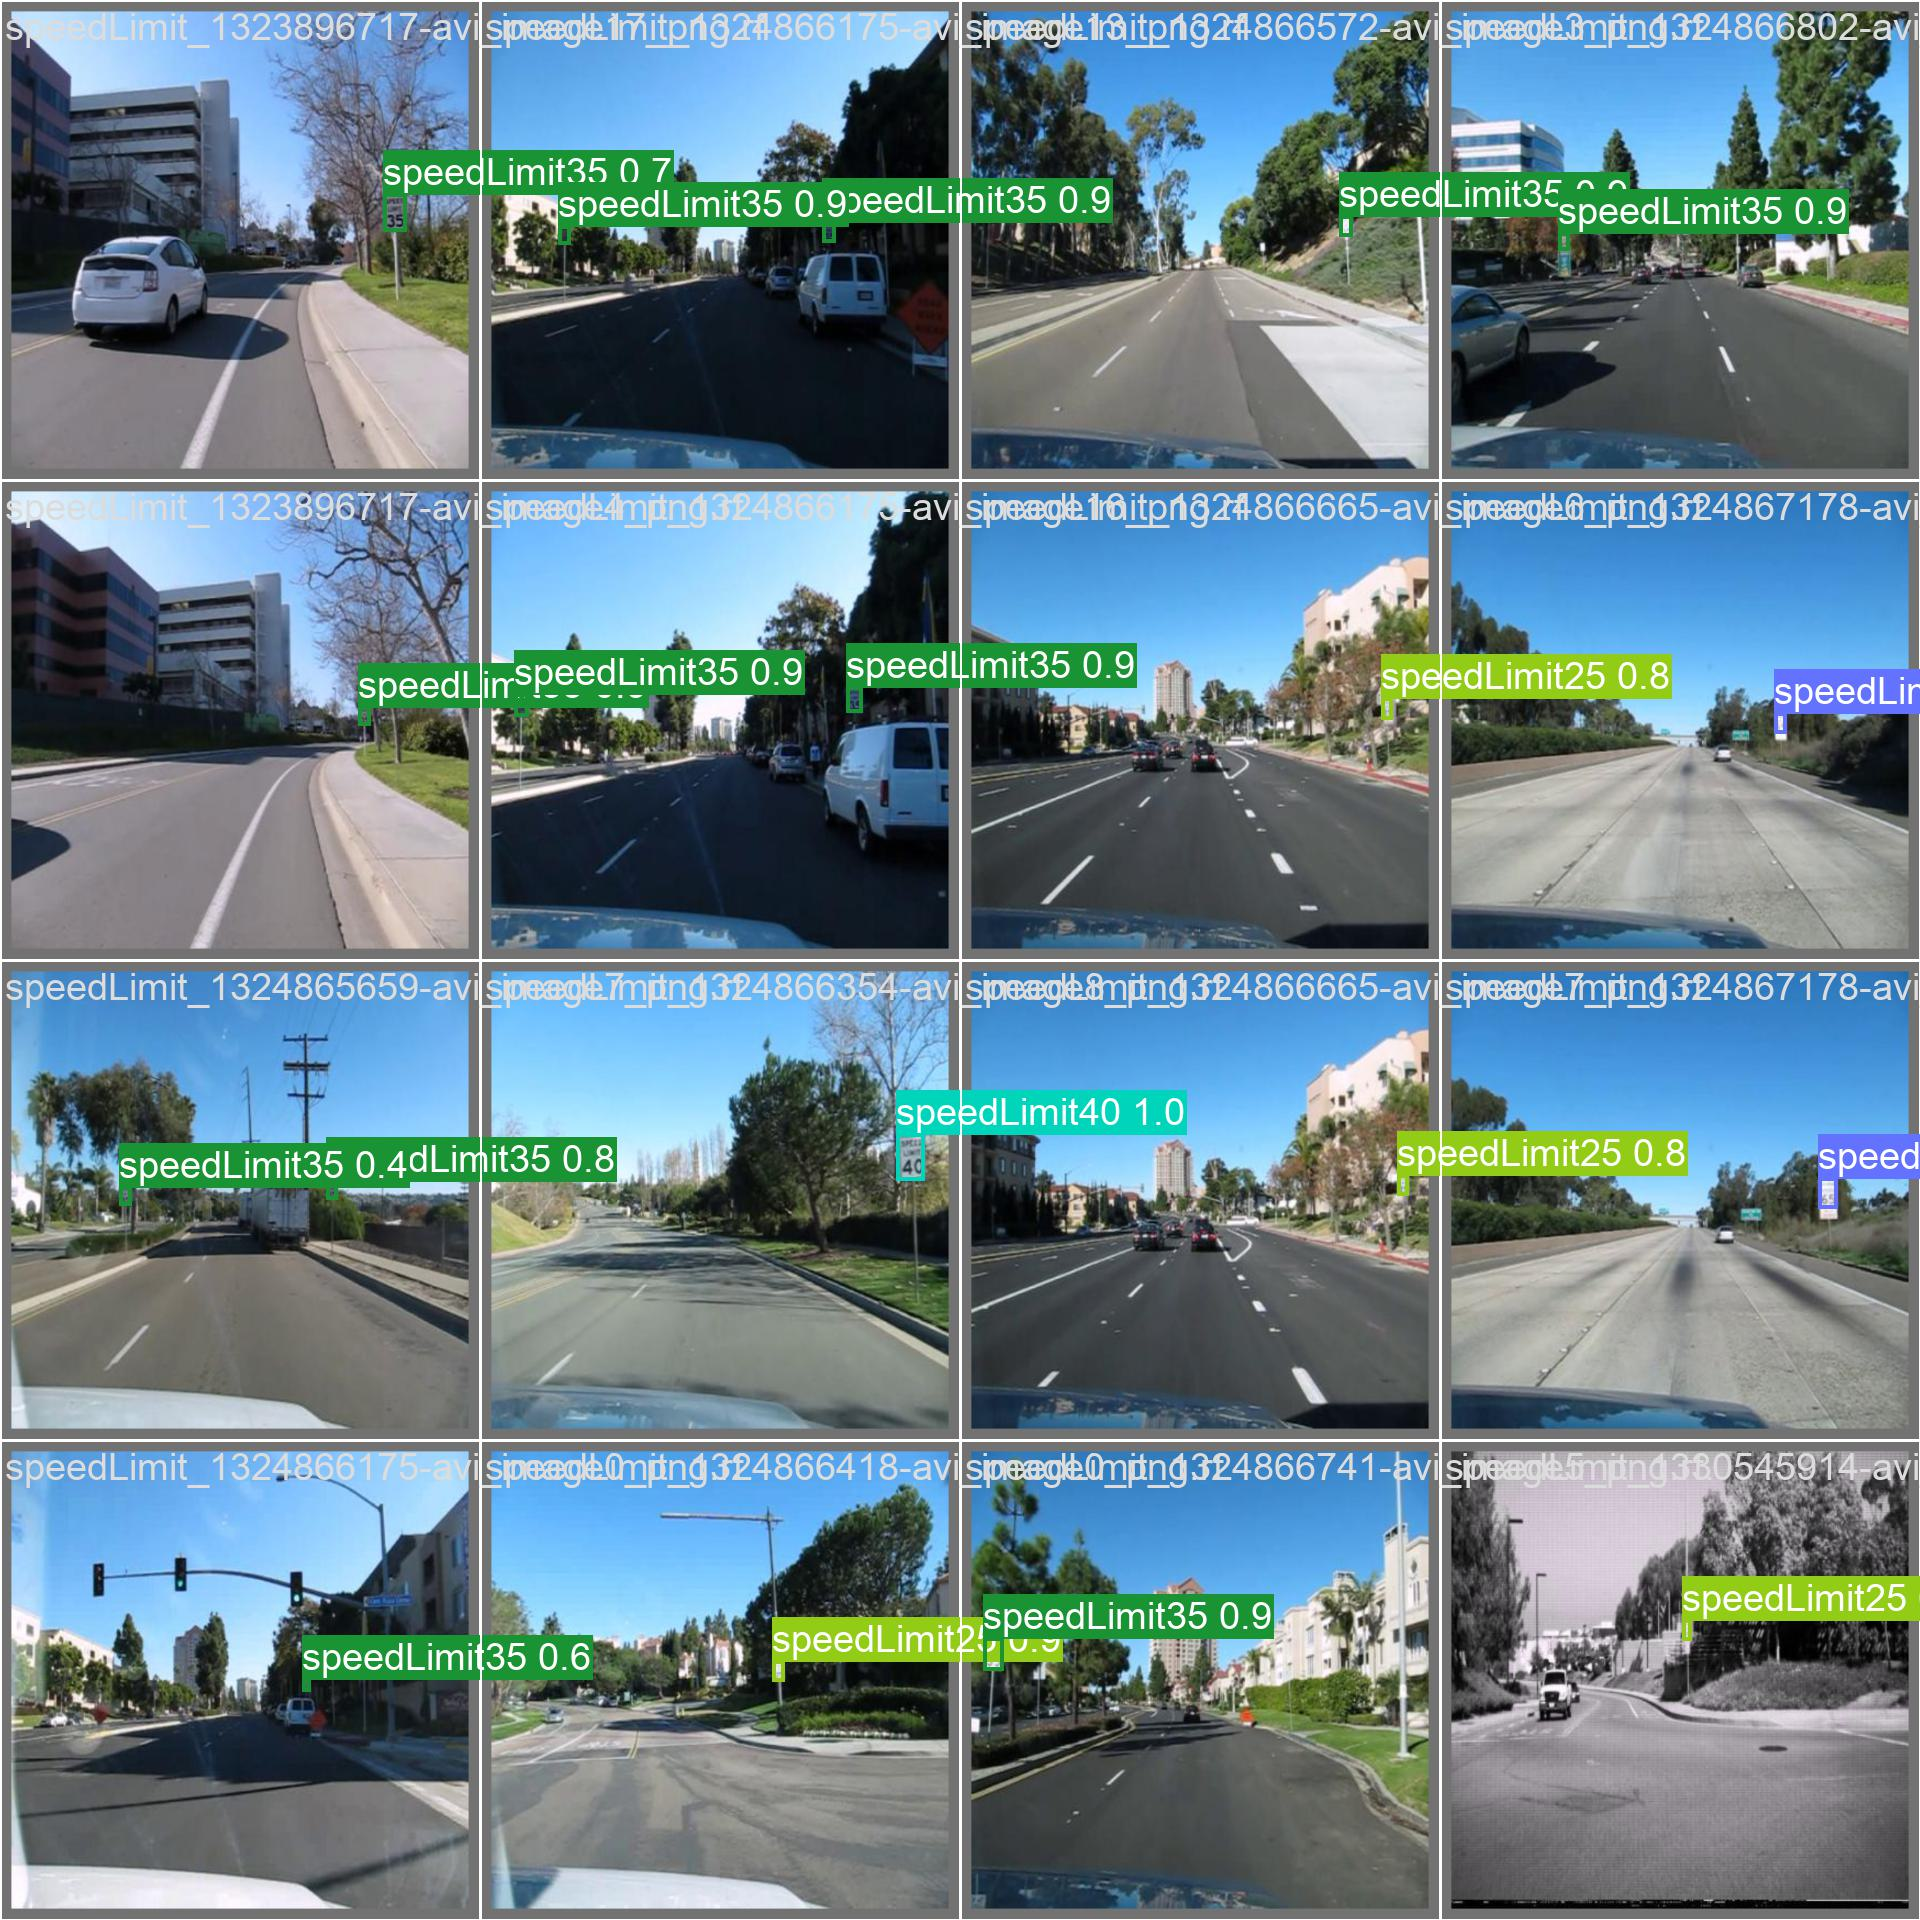

In [11]:
results_path = f'runs/detect/yolo10n_preprocessed9/val_batch1_pred.jpg'
display(Image(filename=results_path))

## Model Evaluation 

In [13]:
# country-lane-street-name-sign-pole-installed-713
inference_res = model('../datasets/Test/country-lane-street-name-sign-pole-installed-713.jpg')
inference_res


image 1/1 /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/AAI521_LisaTrafficSign/../datasets/Test/country-lane-street-name-sign-pole-installed-713.jpg: 640x480 (no detections), 20220.4ms
Speed: 351.9ms preprocess, 20220.4ms inference, 923.2ms postprocess per image at shape (1, 3, 640, 480)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'addedLane', 1: 'curveLeft', 2: 'curveRight', 3: 'dip', 4: 'doNotEnter', 5: 'doNotPass', 6: 'intersection', 7: 'keepRight', 8: 'laneEnds', 9: 'merge', 10: 'noLeftTurn', 11: 'noRightTurn', 12: 'pedestrianCrossing', 13: 'rampSpeedAdvisory20', 14: 'rampSpeedAdvisory35', 15: 'rampSpeedAdvisory40', 16: 'rampSpeedAdvisory45', 17: 'rampSpeedAdvisory50', 18: 'rampSpeedAdvisoryUrdbl', 19: 'rightLaneMustTurn', 20: 'roundabout', 21: 'school', 22: 'schoolSpeedLimit25', 23: 'signalAhead', 24: 'slow', 25: 'speedLimit15', 26: 'speedLimit25', 27: 'speedLimit30', 28: 'speedLimit35', 29: 'speedLimit40', 30: 'speedLimit45', 31: 'speedLimit50', 32: 'speedLimit55', 33: 'speedLimit65', 34: 'speedLimitUrdbl', 35: 'stop', 36: 'stopAhead', 37: 'thruMergeLeft', 38: 'thruMergeRight', 39: 'thruTrafficMergeLeft', 40: 'truckSpeedLimit55', 41: 'turnLeft', 42: 'turnRi

In [4]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from collections import Counter
from matplotlib.image import imread
import cv2
import random
from ultralytics import YOLO
import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import logging
from PIL import Image as PILImage
from IPython.display import Image, display

model = YOLO("runs/detect/yolo10n_preprocessed9/weights/best.pt")

# Path to the input video
filename='IMG_5197'
video_path = f"../datasets/Test/1207/{filename}.MOV"

# Open the video file
video_capture = cv2.VideoCapture(video_path)

# Get video properties
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Output video writer (for saving detected results)
output_path = f"../datasets/Test/1207/{filename}_output.MOV"
#fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec
fourcc = cv2.VideoWriter_fourcc(*"avc1")  # Codec
output_writer = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = video_capture.read()
    if not ret:  # End of video
        break

    # Use YOLO to detect objects in the frame
    results = model(frame)

    # Draw bounding boxes and labels on the frame
    annotated_frame = results[0].plot()

    # Write the annotated frame to the output video
    output_writer.write(annotated_frame)

    # Optional: Display the frame in a window
    cv2.imshow("YOLO Detection", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Quit on 'q' key press
        break


# Release video resources
video_capture.release()
output_writer.release()
cv2.destroyAllWindows()



0: 384x640 1 speedLimit35, 25.0ms
Speed: 1.3ms preprocess, 25.0ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 26.5ms
Speed: 1.4ms preprocess, 26.5ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 speedLimit35, 26.8ms
Speed: 1.3ms preprocess, 26.8ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 speedLimit35, 34.6ms
Speed: 1.2ms preprocess, 34.6ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 speedLimit35, 33.3ms
Speed: 1.8ms preprocess, 33.3ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 speedLimit35, 26.0ms
Speed: 1.2ms preprocess, 26.0ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 24.6ms
Speed: 1.1ms preprocess, 24.6ms inference, 0.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 24.5ms
Speed: 1.2ms preprocess, 24.5ms infere

: 

In [90]:
model = YOLO("runs/detect/yolo10n_preprocessed9/weights/best.pt")   # Load YOLO with pre-trained weights
results = model.predict('../datasets/LISA road signs.v1i.yolov11/test/images/', save=True, plots=True)

   


image 1/662 /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/AAI521_LisaTrafficSign/../datasets/LISA road signs.v1i.yolov11/test/images/addedLane_1323816833-avi_image0_png.rf.2d730070af79d3d1e62192015087029f.jpg: 640x640 1 addedLane, 32.0ms
image 2/662 /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/AAI521_LisaTrafficSign/../datasets/LISA road signs.v1i.yolov11/test/images/addedLane_1323816833-avi_image1_png.rf.a9a81c177d70062b24eba511861c341a.jpg: 640x640 1 addedLane, 31.2ms
image 3/662 /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/AAI521_LisaTrafficSign/../datasets/LISA road signs.v1i.yolov11/test/images/addedLane_1323816833-avi_image9_png.rf.fe38a029872467e0181f486dbcffbcc3.jpg: 640x640 1 addedLane, 30.4ms
image 4/662 /Users/karthikvishwanathraghavan/Documents/MS USD AAI/4. Computer Vision/Final Project/AAI521_LisaTrafficSign/../datasets/LISA road signs.v1i.yolov11/

## Model Inference

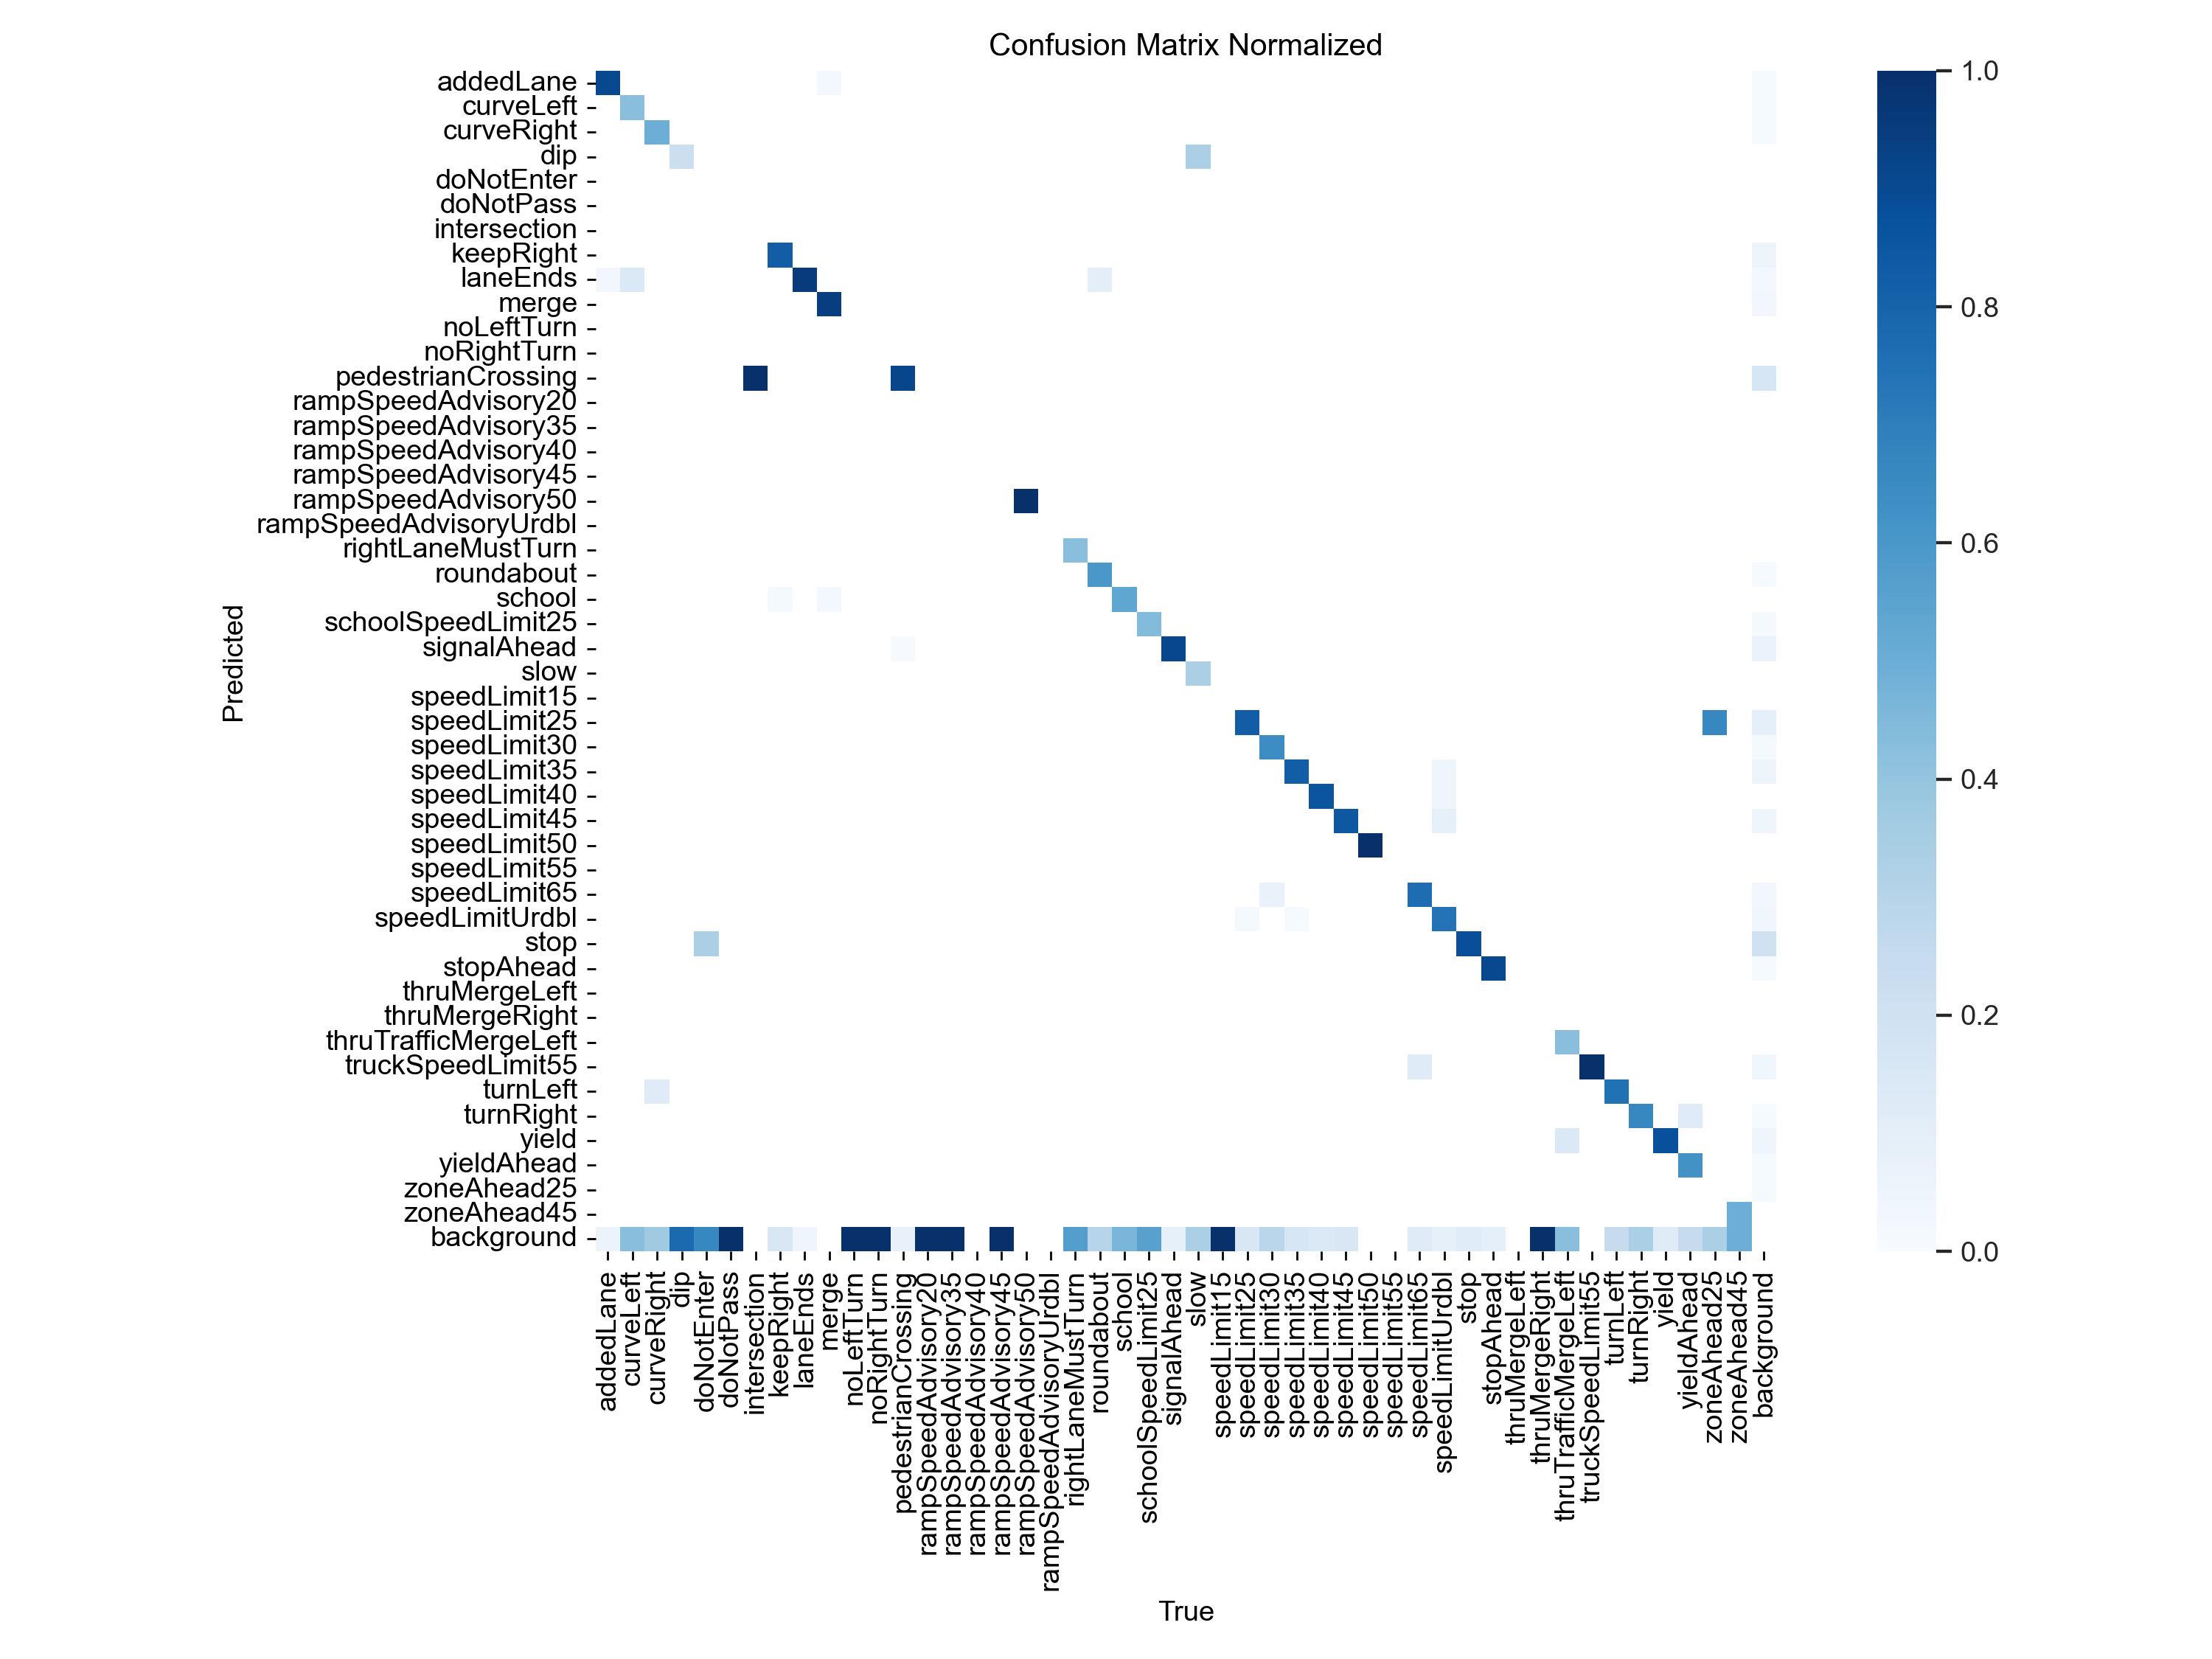

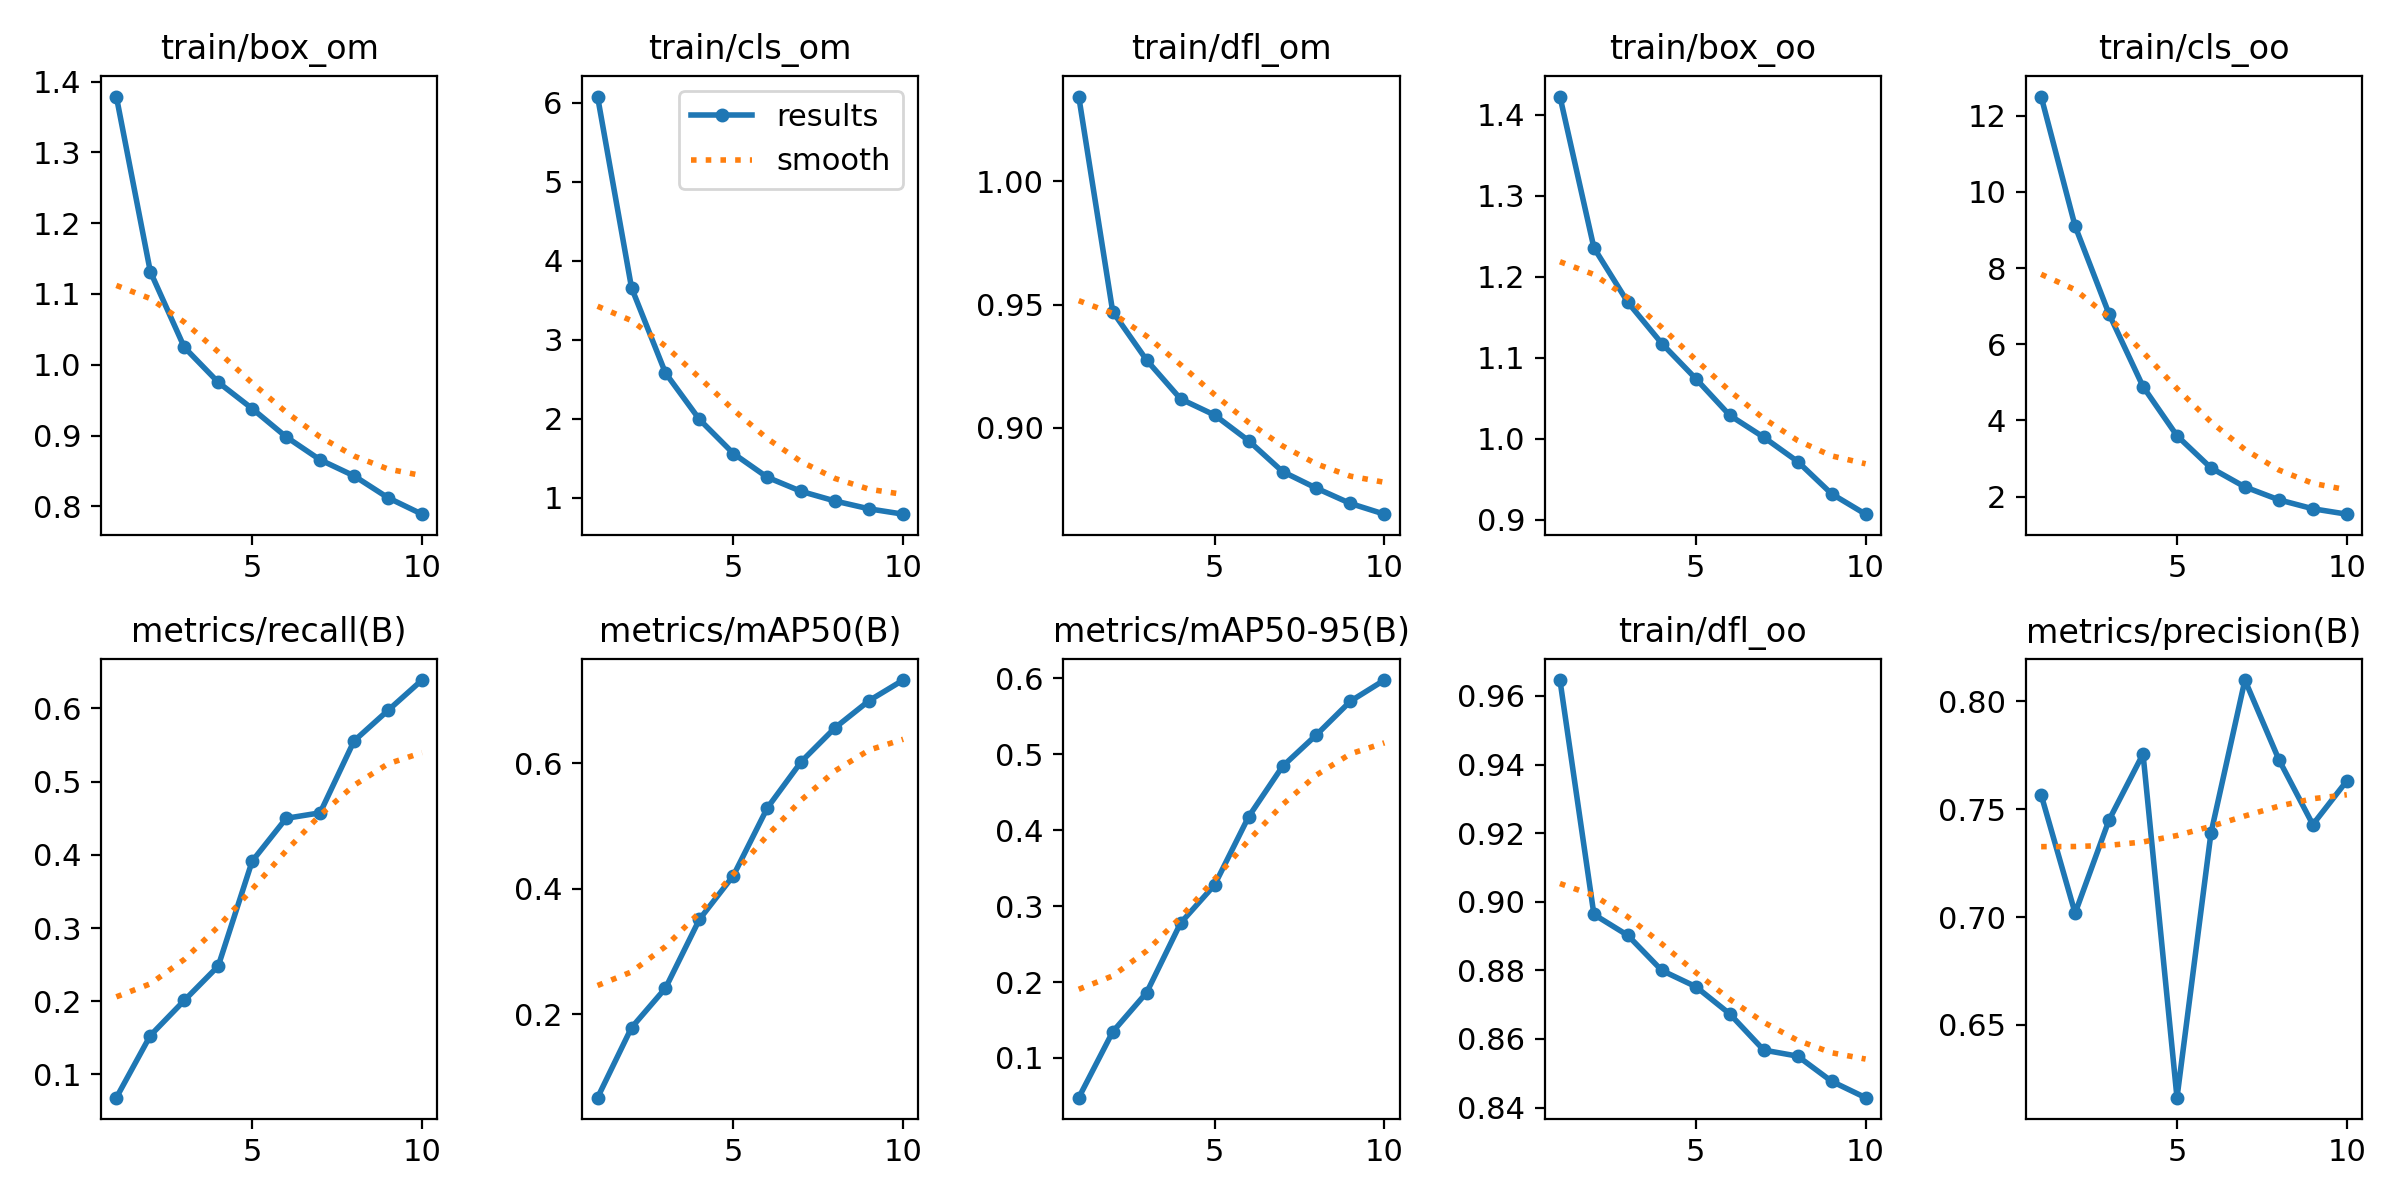

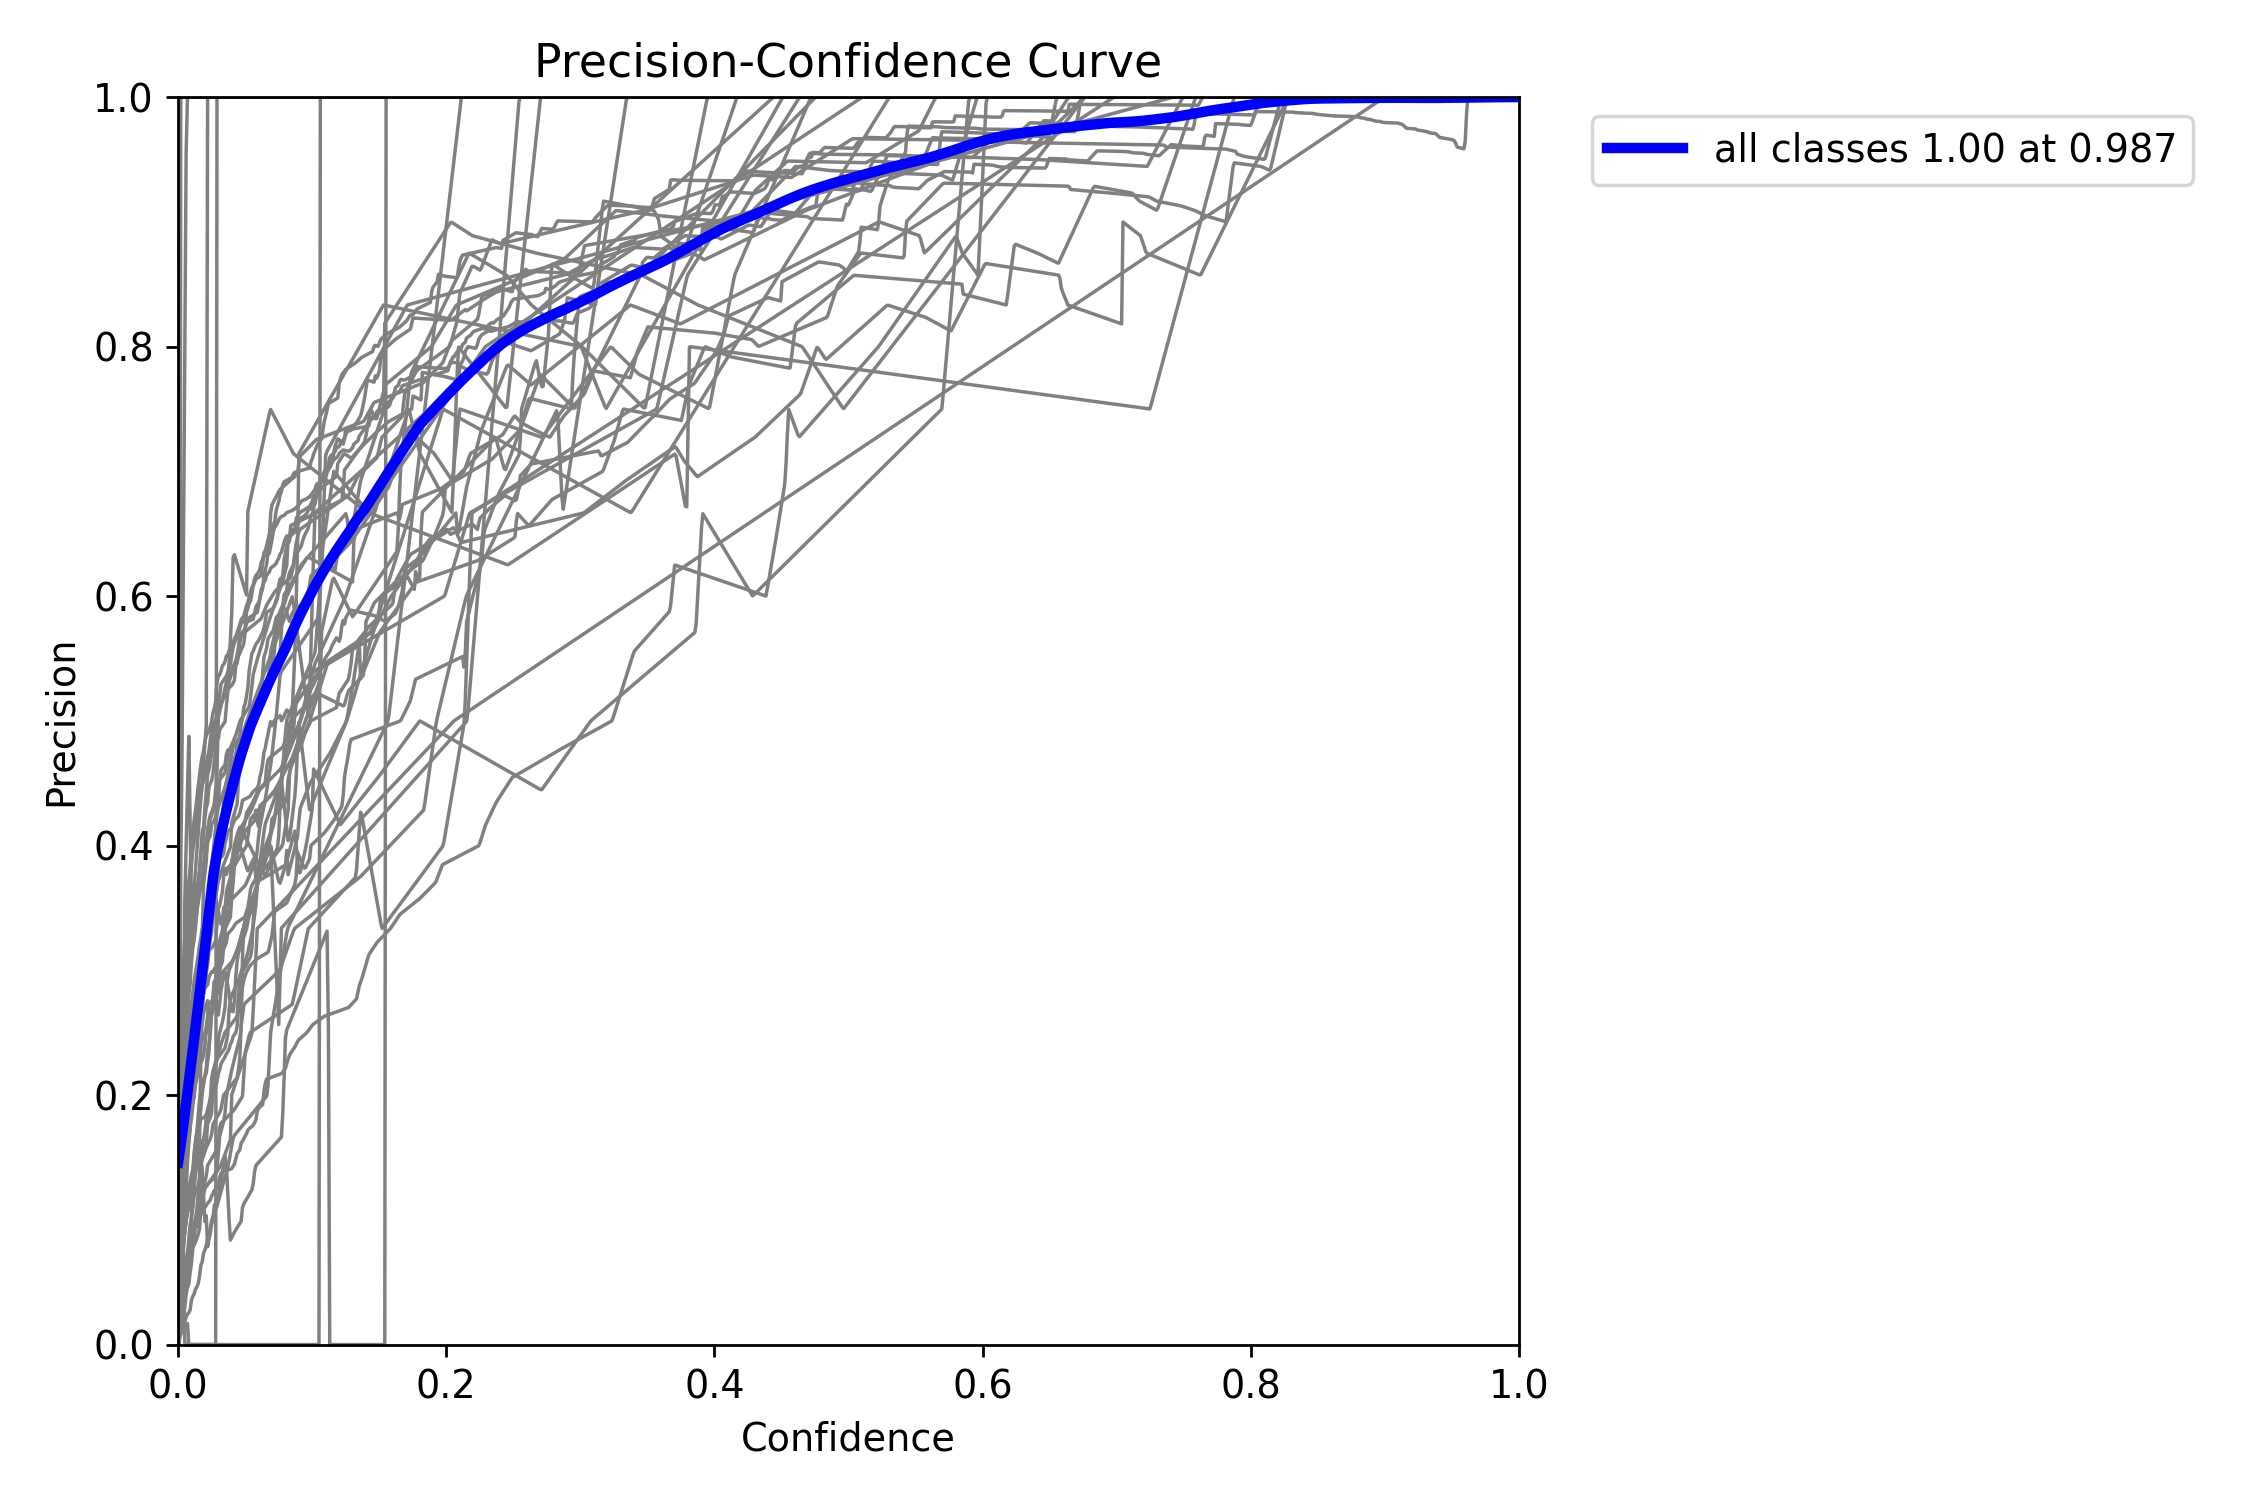

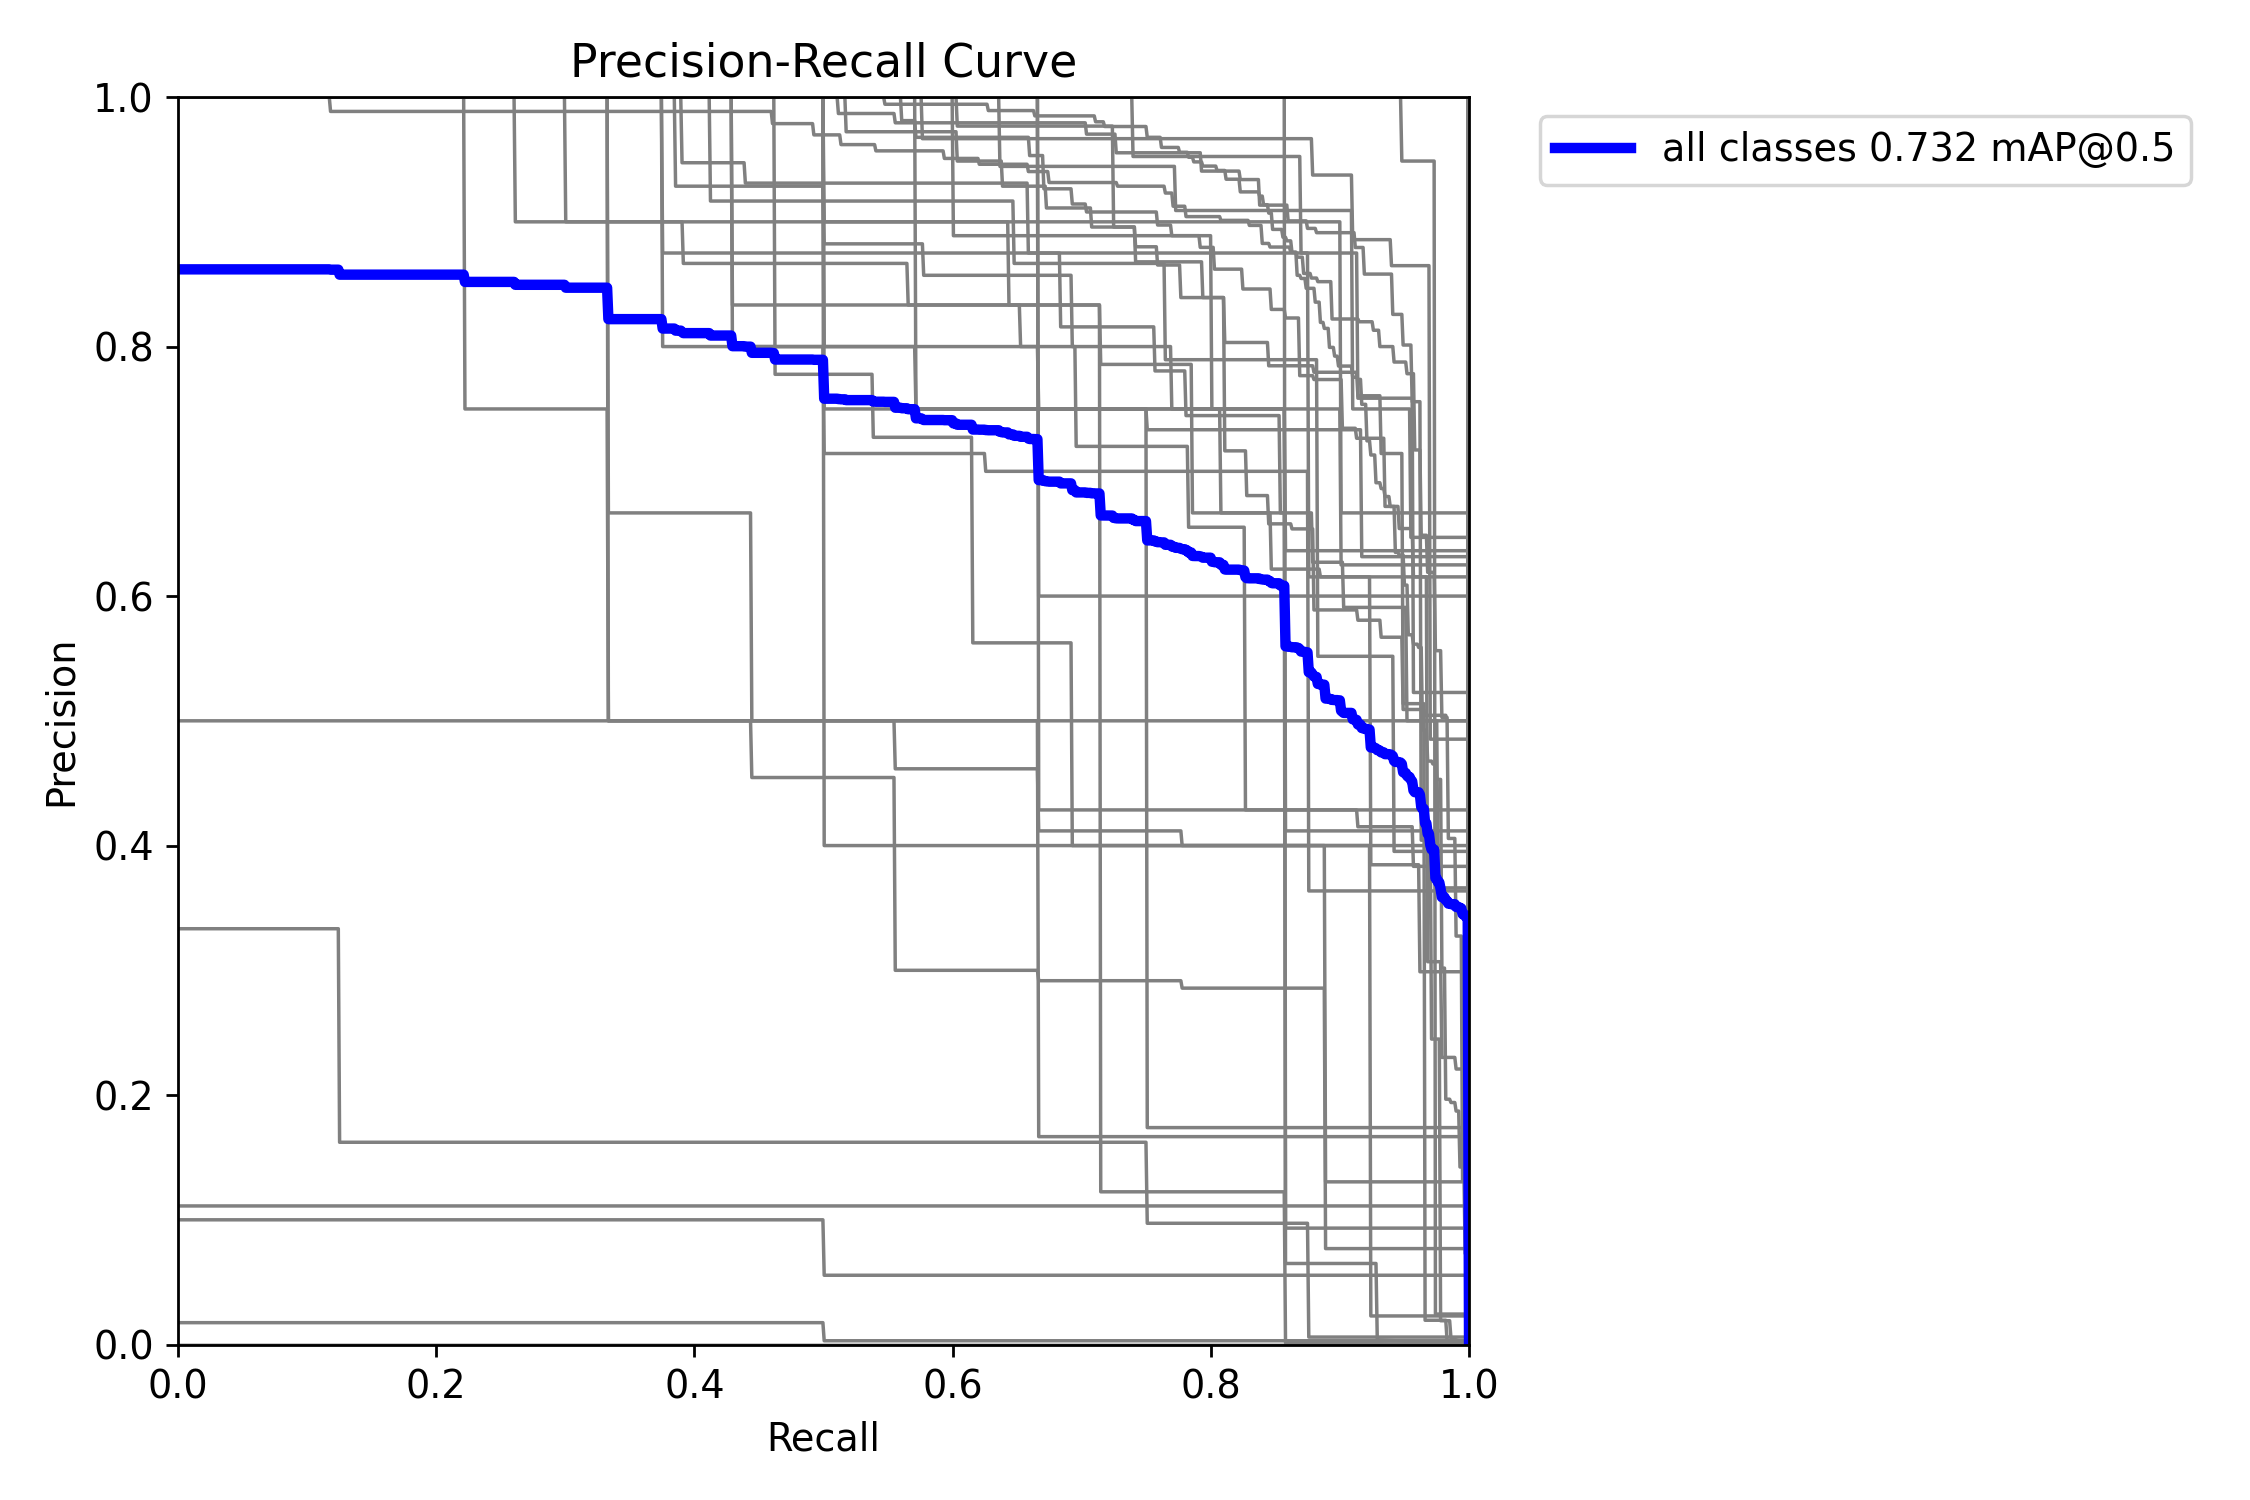

In [115]:
# Show the learning curve and confusion matrix
from PIL import Image as PILImage
from IPython.display import Image, display

# Display confusion matrix
confusion_matrix_path = 'runs/detect/yolo10n_lisa9/confusion_matrix_normalized.png'
display(Image(filename=confusion_matrix_path))

# Display learning curves

results_path = f'runs/detect/yolo10n_lisa9/results.png'
display(Image(filename=results_path))

results_path = f'runs/detect/yolo10n_lisa9/P_curve.png'
display(Image(filename=results_path))

results_path = f'runs/detect/yolo10n_lisa9/PR_curve.png'
display(Image(filename=results_path))

### Confusion Matrix
Most predictions lie along the diagonal, indicating good performance for many classes.
There are some misclassifications (off-diagonal entries), but the intensity is low, implying these are relatively rare.

### Precision-Recall Curve

The blue line of the Precision-Recall curve corresponds to a mAP@0.5 score of 0.963, which indicates the mean Average Precision (mAP) at 50% Intersection over the Union (IoU) threshold is 96.3%. This is an excellent result. The confidence threshold of 0.665 is the point at which precision and recall are best balanced across all classes.

### F1 Curve
The blue line's peak marks the highest F1 score achieved (0.93) at the optimal confidence threshold (0.665). This threshold is ideal for balancing precision and recall.

